Notes from meeting with Thomas, O'Sheg, Chuck, Stoyan (11am):
- For both Mu2e and ORNL PPU, ultimate desire is the following info for each probe:
    - Location (x,y,z) and orientation (Rx, Ry, Rz ?) of glass cube corner / COG of Hall elements.
    - These values must be in the appropriate reference frame, or be able to do the chain of transformations to get to the appropriate reference frame.
        - ORNL this is the test setup in IB1.
        - For Mu2e this needs to happen in two different locations:
            1. Calibration setup -- kinematic mounting points as Hall probe reference
            2. DSFM -- kinematic mounting points as Hall probe reference            
- It seems that the chain of survey steps has been completed, by different people/leads. It is not clear that each group measured enough that they can be referenced together and give us what we need.
- Ted Beale (and co.) did measurements of the Hall probe card / kinematic mounting. Anything I'm forgetting?
- Chuck seems to remember Jana extracting the useful numbers from log files from Ted. Not sure if this needs to happen again.
- Chuck (and co.) did a measurement of the Hall probe glass cube corner. (Not sure if orientation measurements were completed?)
    - Note Chuck said a previous analysis assumed perfectly cubic glass.
- Stoyan said the ORNL deadline is June 2023, but most likely will be done sooner than that.

- Thomas said (privately) that ORNL work is good because it is helping with debugging EMMA.

# Background

- Starting a new notebook for the new angular dataset after epoxy to fix the loose screws.

# Imports

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
import numpy as np
import pandas as pd
from copy import deepcopy
import pickle as pkl
from collections.abc import Iterable
# from datetime import datetime
# from datetime import timedelta
# from pandas.api.types import is_numeric_dtype
from scipy.interpolate import interp1d
from scipy.spatial.transform import Rotation
import lmfit as lm
# from copy import deepcopy
#from dateutil import parser
# from plotly import graph_objects as go
# from plotly.offline import plot
import matplotlib.pyplot as plt
# from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# local imports
# from plotting import config_plots, datetime_plt, get_label
from plotting import config_plots, get_label
from load_slow import *
from Zaber_Magnet_Convert import *
# hallprobecalib package
from hallprobecalib.hpcplots import scatter3d, scatter2d, histo, spherical_scatter3d
from mu2e.mu2eplots import mu2e_plot3d
# V vs. B, T (2021 results)
from V_vs_B_T import V_forward, inv_B_v2, invert_row, calc_B_column

config_plots()
# plt.rcParams.update({"text.usetex": True})

# Functions

## Processing

In [ ]:
def get_probe_IDs(df):
    probes = [c[:-6] for c in df.columns if "Raw_X" in c]
    return sorted(probes)

def Hall_probe_basic_calcs(df, probes):
    # magnitudes and angles
    for p in probes:
        for t in ['Raw', 'Cal']:
            df[f'{p}_{t}_Bmag'] = (df[f'{p}_{t}_X']**2 + df[f'{p}_{t}_Y']**2 + df[f'{p}_{t}_Z']**2)**(1/2)
            df[f'{p}_{t}_Theta'] = np.arccos(df[f'{p}_{t}_Z']/df[f'{p}_{t}_Bmag'])
            df[f'{p}_{t}_Phi'] = np.arctan2(df[f'{p}_{t}_Y'],df[f'{p}_{t}_X'])
    # again using theta redefining Cal components
    for p in probes:
        for t in ['Cal']:
            df[f'{p}_{t}_Theta2'] = np.arccos(df[f'{p}_{t}_X']/df[f'{p}_{t}_Bmag'])
            df[f'{p}_{t}_Phi2'] = np.arctan2(df[f'{p}_{t}_Z'],df[f'{p}_{t}_Y'])
        ### flip phi when theta < 0 (-2)
        '''
        #inds = np.where(df.loc[:, f'{p}_Cal_Theta2'] < -2.0)
        inds = np.where((df.loc[:, 'SmarAct_Meas_Angle_1'] >= 349) & (df.loc[:, 'SmarAct_Meas_Angle_1'] <= 358))
        print(df.iloc[inds][f'{p}_Cal_Phi2'].iloc[0])
        df.loc[df.index[inds], f'{p}_Cal_Phi2'] = df.loc[df.index[inds], f'{p}_Cal_Phi2'] - np.pi
        print(df.iloc[inds][f'{p}_Cal_Phi2'].iloc[0])
        inds2 = np.where(df.loc[:, f'{p}_Cal_Phi2'] < -np.pi)
        print(df.iloc[inds2][f'{p}_Cal_Phi2'].iloc[0])
        df.loc[df.index[inds2], f'{p}_Cal_Phi2'] = df.loc[df.index[inds2], f'{p}_Cal_Phi2'] + 2*np.pi
        print(df.iloc[inds2][f'{p}_Cal_Phi2'].iloc[0])
        '''
    # magnet slow controls
    df['Magnet Resistance [Ohm]'] = df['Magnet Voltage [V]'] / df['Magnet Current [A]']
    df['Coil Resistance [Ohm]'] = 2*df['Magnet Resistance [Ohm]']
    df['Magnet Power [W]'] = df['Magnet Voltage [V]'] * df['Magnet Current [A]']
    # center smaract measured values around zero
    a1 = df.loc[:, 'SmarAct_Meas_Angle_1'].copy().values
    a2 = df.loc[:, 'SmarAct_Meas_Angle_2'].copy().values
    a1[a1 > 180.] = a1[a1 > 180.] - 360.
    a2[a2 > 180.] = a2[a2 > 180.] - 360.
    df.loc[:, 'SmarAct_Meas_Angle_1_Centered'] = a1
    df.loc[:, 'SmarAct_Meas_Angle_2_Centered'] = a2
    ### INTERPOLATE NMR VALUES TO SCAN TIMES
    #### STOPPED HERE 2022-11-29 17:41:36 
    return df

def match_temp_scan_dfs(df_temp, df):
    # assumes scan df is a subset of temp df.
    t0 = df.index[0]
    tf = df.index[-1]
    df_t = df_temp.query(f'"{t0}" <= Datetime <= "{tf}"').copy()
    return df_t

def interp_temp_col(df_temp, df, col='NMR [T]'):
    interp_func = interp1d(df_temp.seconds_delta, df_temp[col].values, kind='linear', fill_value='extrapolate')
    df.loc[:, col] = interp_func(df.seconds_delta)
    return df

# File Info

In [ ]:
ddir_old = '/home/ckampa/Dropbox/LogFiles/temp_rotate_07-06-22/' # old scans
ddir = '/home/ckampa/Dropbox/LogFiles/temp_rotate_01-09-23/' # new scans

In [ ]:
"""
#### BEFORE FIX!
# 7-7-22 12:04, probe ##, rotating in magnet, finer scan
# PGC @ 15 deg C
# 0.25 deg steps -10 -- +6 angle 0 (theta)
# 1 deg steps full 360 deg, centered on 0 deg angle 1 (phi)
######
plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_rotate/2022-07-07_12:04/'
scanfile = ddir_old+'2022-07-07 120406.txt'
slowfile = ddir_old+'2022-07-06 133626slow.txt'
t0 = '07-07-22 12:00' # finer scan started
tf = '07-09-22 18:42' # finer scan finished
""";

In [ ]:
# 01-09-22 12:00, probe ##, rotating in magnet, coarse scan
# PGC @ 20 deg C
# 2 deg steps -9 -- +5 angle 0 (theta)
# 45 deg steps full 360 deg, centered on -16 deg angle 1 (phi)
######
# plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_rotate/2023-01-09_12:00/'
# scanfile = ddir+'2023-01-09 120012.txt'
# slowfile = ddir+'2023-01-09 104334slow.txt'

In [ ]:
# """
# 7-7-22 12:04, probe ##, rotating in magnet, finer scan
# PGC @ 20 deg C
# 0.25 deg steps -9.5 -- +5.5 angle 0 (theta)
# 1 deg steps full 360 deg, centered on 0 deg angle 1 (phi)
######
plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_rotate/2023-01-09_12:26/'
scanfile = ddir+'2023-01-09 122622.txt'
slowfile = ddir+'2023-01-09 104334slow.txt'
#### scan 1
'''
#t0 = '01-09-23 11:50' # magnet on
#tf = '01-09-23 12:20' # coarse scan end
t0 = '01-09-23 20:29' # finer scan start
#tf = '01-11-23 00:00' # PLACEHOLDER
##tf = '01-10-23 11:45:22' # magnet tripped during finer scan
tf = '01-10-23 11:45:10' # magnet tripped during finer scan
'''
#### scan 2
#t0 = '01-13-23 10:25' # magnet on
# t0 = '01-14-23 00:00' # finer scan 2 started
# tf = '01-16-23 05:56' # finer scan 2 finished
#### scan 3 (repeatability)
t0 = '01-16-23 08:55' # finer scan 3 started
# tf = '01-18-23 15:25' # finer scan 3 finished
#### scan 4 (10 deg)
#t0 = '01-18-23 15:25' # finer scan 3 finished
# t0 = '01-18-23 17:00' # temperature set to 10 deg C
#t0 = '01-19-23 10:43' # finer scan 4 started (10 deg C)
# tf = '01-21-24 18:21' # finer scan 4 ended
#### scan 5 (40 deg). SmarAct failed in the middle. Overheating?
# t0 = '01-21-23 18:21' # finer scan 4 finished
# t0 = '01-21-23 19:00' # temperature set to 40 deg C
# t0 = '01-22-23 06:37' # finer scan 5 started (40 deg C)
tf = '01-23-23 00:00' # finer scan 5 failed
# tf = '01-01-24 00:00' # PLACEHOLDER
# """;

- Note the above files include one partial scan (magnet off at -5.25 deg angle 1).
- Magnet restarted 01-13-23 10:25am.
- Second scan started 01-13-23 ##:##pm.

# Load and Process Data

In [ ]:
# temperature
df_temp = load_data(slowfile)
# only include times with NMR?
#df_temp = df_temp.query('`NMR [T]` > 0.9').copy()
# scan data
df = load_data(scanfile).iloc[1:]
# interpolations from temp to scan
for col in ['NMR [T]']:
    df = interp_temp_col(df_temp, df, col=col)
# time slices?
df = df.query(f'"{t0}" <= Datetime <= "{tf}"').copy()
df_temp = df_temp.query(f'"{t0}" <= Datetime <= "{tf}"').copy()

In [ ]:
df

In [ ]:
probes = get_probe_IDs(df)
probe = probes[0]
probes

In [ ]:
df = Hall_probe_basic_calcs(df, probes)

In [ ]:
df_t = match_temp_scan_dfs(df_temp, df)

In [ ]:
df

In [ ]:
smar_cols = [c for c in df.columns if "SmarAct" in c]

In [ ]:
df[smar_cols]

# Exploratory Plotting

## Basics

- 2023-01-09 20:33:52 **Please adjust to have same x axes!!**

In [ ]:
'''
#t0_ = '01-09-23 11:50' # magnet on
#tf_ = '01-09-23 12:20' # coarse scan end
t0_ = '01-09-23 20:29' # finer scan start
#tf_ = '01-11-23 00:00' # PLACEHOLDER
##tf_ = '01-10-23 11:45:22' # magnet tripped during finer scan
tf_ = '01-10-23 11:45:10' # magnet tripped during finer scan
df_ = df.query(f"'{t0_}' <= Datetime <= '{tf_}'").copy()
# df_t_ = df_t.query(f"'{t0_}' <= Datetime <= '{tf_}'").copy()
df_t_ = df_temp.query(f"'{t0_}' <= Datetime <= '{tf_}'").copy()
'''

df_ = df.copy()
df_t_ = df_temp.copy()

fig = plt.figure(figsize=(14, 16))
##ax = plt.subplot(211)
ax = plt.axes([0.1, 0.4, 0.8, 0.5])
#ax2 = plt.subplot(212, sharex=ax)
ax2 = ax.twinx()
ax3 = plt.axes([0.1, 0.1, 0.8, 0.25])
##ax3 = plt.subplot(212, sharex=ax)
ax4 = ax3.twinx()
df_[f'{probe}_Cal_Bmag'].plot(ax=ax, color='blue')
# df_[f'{probe}_Raw_Bmag'].plot(ax=ax, color='blue')
df_t_['NMR [T]'].plot(ax=ax2, color='red')
df_['SmarAct_Meas_Angle_2_Centered'].plot(ax=ax3, color='black', linestyle='None', marker='.')
df_['SmarAct_Meas_Angle_1_Centered'].plot(ax=ax4, color='green', linestyle='None', marker='.')
ax.set_ylabel(f'Hall probe |B| [T]')
ax.yaxis.label.set_color('blue')
ax2.set_ylabel(f'NMR |B| [T]')
ax2.yaxis.label.set_color('red')
ax3.set_ylabel('SmarAct Angle 2 [Rad], centered')
ax4.set_ylabel('SmarAct Angle 1 [Rad], centered')
ax3.yaxis.label.set_color('black')
ax4.yaxis.label.set_color('green')
ax.set_title(f"|B| Comparisons for Hall Probe: {probe}\n")

In [ ]:
df_.tail()

In [ ]:
temps_list = list(df_temp.columns)
[temps_list.remove(i) for i in ['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'NMR [T]', 'NMR [FFT]', 'seconds_delta', 'hours_delta', 'days_delta']]

In [ ]:
#temps_list

In [ ]:
len(temps_list)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))

for c in temps_list[:20]:
    ax.plot(df_temp.index, df_temp[c], label=c)
    
ax.set_xlabel('Datetime')
ax.set_ylabel('Temp [deg C]')
ax.legend(ncol=3, bbox_to_anchor=(1., 1.), loc='upper left');

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))

for c in temps_list[20:]:
    ax.plot(df_temp.index, df_temp[c], label=c)
    
ax.set_xlabel('Datetime')
ax.set_ylabel('Temp [deg C]')
ax.legend(ncol=3, bbox_to_anchor=(1., 1.), loc='upper left');

In [ ]:
#temps_list

In [ ]:
# only in the chamber
temps_ch = [a for a in df.columns if ("CH" in a) and int(a[-2:])<21]# or "HVAC" in a]
temps_ch.append("Hall Element")
temps_ch.append("Floor")
temps_ch.append("Roof")
temps_ch.append("Yoke (center magnet)")
temps_ch.append("Yoke (near pole)")

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))

for c in temps_ch:
    ax.plot(df_temp.index, df_temp[c], label=c)

ax.plot(df.index, df[f'{probe}_Cal_T'], label=f'{probe}')
    
ax.set_xlabel('Datetime')
ax.set_ylabel('Temp [deg C]')
ax.legend(ncol=1, bbox_to_anchor=(1., 1.), loc='upper left');

In [ ]:
for a in ['1', '2']:
    fig, ax = plt.subplots()

    ax.scatter(df[f'SmarAct_Meas_Angle_{a}_Centered'], df[f'{probe}_Cal_T'], s=1)

    ax.set_xlabel(f'SmarAct {a} [rad] centered')
    ax.set_ylabel(f'{probe}_Cal_T [deg C]');

In [ ]:
#q_str = '"01-20-23 09:00" < Datetime < "01-01-24"'
q_str = '`NMR [T]` > 0'
df_temp_ = df_temp.query(q_str).copy()
df_hp_ = df.query(q_str).copy()


fig, ax = plt.subplots(figsize=(18, 8))

for c in temps_ch:
    ax.plot(df_temp_.index, df_temp_[c], label=c)

ax.plot(df_hp_.index, df_hp_[f'{probe}_Cal_T'], label=f'{probe}')
    
ax.set_xlabel('Datetime')
ax.set_ylabel('Temp [deg C]')
ax.legend(ncol=1, bbox_to_anchor=(1., 1.), loc='upper left');

In [ ]:
fig, ax = plt.subplots()\

ax.scatter(df_[f'{probe}_Raw_Bmag'], df_[f'{probe}_Cal_Bmag'], s=1)

ax.set_xlabel('|V| [ADC]')
ax.set_ylabel('|B| [T]');

In [ ]:
(2.804-2.790) / 2.796

In [ ]:
fig, ax = plt.subplots()\

ax.scatter(df_['NMR [T]'], df_[f'{probe}_Cal_Bmag'], s=1)

ax.set_xlabel('NMR [T]')
ax.set_ylabel('|B| [T]');

## Correlations

In [ ]:
fig, ax = plt.subplots()


ax.scatter(df_['SmarAct_Meas_Angle_2_Centered'], df_[f'NMR [T]'], s=1)

ax.set_xlabel('SmarAct 2 [rad] centered')
ax.set_ylabel('NMR [T]');

In [ ]:
fig, ax = plt.subplots()


ax.scatter(df_['SmarAct_Meas_Angle_1_Centered'], df_[f'NMR [T]'], s=1)

ax.set_xlabel('SmarAct 1 [rad] centered')
ax.set_ylabel('NMR [T]');

In [ ]:
fig, ax = plt.subplots()


ax.scatter(df_['SmarAct_Meas_Angle_2_Centered'], df_[f'{probe}_Raw_Phi'], s=1)

ax.set_ylabel(f'{probe}_Raw_Phi')
ax.set_xlabel('SmarAct 2 [rad] centered');

In [ ]:
fig, ax = plt.subplots()
#ax.hist(df_[f'{probe}_Raw_Theta'], bins=75, histtype='step');
ax.scatter(df_['days_delta'], df_[f'{probe}_Raw_Theta'], s=1);

ax.set_xlabel(f'Time from start (days)')
ax.set_ylabel(f'{probe}_Raw_Theta');

In [ ]:
fig, ax = plt.subplots()
#ax.hist(df_[f'{probe}_Raw_Theta'], bins=75, histtype='step');
ax.scatter(df_['SmarAct_Meas_Angle_1_Centered'], df_[f'{probe}_Raw_Theta'], s=1);

ax.set_xlabel(f'SmarAct 1 [rad] centered')
ax.set_ylabel(f'{probe}_Raw_Theta');

In [ ]:
# check flip of Angle 2 by pi (plate is now upside-down)
a2_flipped = np.radians(df_['SmarAct_Meas_Angle_2_Centered']) - np.pi
a2_flipped[a2_flipped<-np.pi] = a2_flipped[a2_flipped<-np.pi]+2*np.pi

In [ ]:
df_.SmarAct_Meas_Angle_1_Centered

In [ ]:
fig, ax = plt.subplots()

#ax.scatter(np.radians(df_['SmarAct_Meas_Angle_2_Centered']), df_[f'{probe}_Raw_Phi'], s=1)
#ax.scatter(a2_flipped, df_[f'{probe}_Raw_Phi'], s=1)
sc = ax.scatter(a2_flipped, df_[f'{probe}_Raw_Phi'], c=df_.SmarAct_Meas_Angle_1_Centered, s=4)
cb = fig.colorbar(sc, label='SmarAct 1 [deg], centered')

# zoom in
# ax.set_xlim([-np.pi-0.01, -2.0])
# ax.set_ylim([-np.pi-0.01, -1.7])
# ax.set_xlim([-np.pi-0.01, -3.0])
# ax.set_ylim([-2.0, -1.55])

# ax.set_xlim([-0.01, 0.01])
# ax.set_ylim([1.194, 1.203])

# ax.set_xlim([-1., 1.0])
# ax.set_ylim([0., 1.8])

ax.set_facecolor('gray')

ax.set_xlabel(r'(SmarAct 2 [rad] centered)  - $\pi$, (re-centered)')
ax.set_ylabel(f'{probe}_Raw_Phi');

In [ ]:
# NOT -PI
fig, ax = plt.subplots()

#ax.scatter(np.radians(df_['SmarAct_Meas_Angle_2_Centered']), df_[f'{probe}_Raw_Phi'], s=1)
#ax.scatter(a2_flipped, df_[f'{probe}_Raw_Phi'], s=1)
sc = ax.scatter(np.radians(df_.SmarAct_Meas_Angle_2_Centered), df_[f'{probe}_Raw_Phi'], c=df_.SmarAct_Meas_Angle_1_Centered, s=4)
cb = fig.colorbar(sc, label='SmarAct 1 [deg], centered')

# zoom in
# ax.set_xlim([-np.pi-0.01, -2.0])
# ax.set_ylim([-np.pi-0.01, -1.7])
# ax.set_xlim([-np.pi-0.01, -3.0])
# ax.set_ylim([-2.0, -1.55])

# ax.set_xlim([-0.01, 0.01])
# ax.set_ylim([1.194, 1.203])

ax.set_facecolor('gray')

ax.set_xlabel(r'(SmarAct 2 [rad] centered)  - $\pi$, (re-centered)')
ax.set_ylabel(f'{probe}_Raw_Phi');

In [ ]:
df_.SmarAct_Meas_Angle_1_Centered.round(1).unique()

In [ ]:
len(df_.SmarAct_Meas_Angle_1_Centered.round(1).unique())

- This seems to match the previous results from a finer scan.

In [ ]:
df_.SmarAct_Meas_Angle_1_Centered

In [ ]:
df_.SmarAct_Meas_Angle_1

In [ ]:
fig, ax = plt.subplots()


ax.scatter(df_['SmarAct_Meas_Angle_1_Centered'], df_[f'{probe}_Raw_Z'], s=1)

ax.set_xlabel('SmarAct 1 [rad] centered')
ax.set_ylabel(f'{probe}_Raw_Z');

In [ ]:
fig, ax = plt.subplots()
ax.hist(df_[f'{probe}_Raw_Theta'], bins=75, histtype='step')
ax.set_xlabel(f'{probe}_Raw_Theta');

In [ ]:
df['2F0000000D5EC73A_Raw_Phi']

In [ ]:
##### calibrated info

In [ ]:
fig, ax = plt.subplots()

ax.scatter(np.radians(df_['SmarAct_Meas_Angle_1_Centered']), df_[f'{probe}_Cal_Theta2'], s=1);

ax.set_xlabel(f'SmarAct 1 [rad] centered')
ax.set_ylabel(f'{probe}_Cal_Theta (redef. Cal components)');

In [ ]:
np.arccos(1.0 / 10.0), np.arccos(-1.0 / 10.0)

In [ ]:
df_[['2F0000000D5EC73A_Raw_Z', '2F0000000D5EC73A_Cal_X']]

In [ ]:
df_[['2F0000000D5EC73A_Raw_Y', '2F0000000D5EC73A_Cal_Y']]

In [ ]:
df_[['2F0000000D5EC73A_Raw_X', '2F0000000D5EC73A_Cal_Z']]

In [ ]:
df_upside_down = df_[np.isclose(df_.SmarAct_Meas_Angle_2_Centered, -16)]
df_pos90 = df_[np.isclose(df_.SmarAct_Meas_Angle_2_Centered, -16+90)]

In [ ]:
-16+90

In [ ]:
for i in ['X', 'Y', 'Z']:
    print(i)
    print(np.ptp(df_upside_down[f'2F0000000D5EC73A_Cal_{i}']))
    fig, ax = plt.subplots()

    ax.scatter(df_upside_down.SmarAct_Meas_Angle_1_Centered, df_upside_down[f'2F0000000D5EC73A_Cal_{i}'])

    ax.set_xlabel('SmarAct1 [deg]')
    ax.set_ylabel(f'Cal {i} [T]')

In [ ]:
for i in ['X', 'Y', 'Z']:
    print(i)
    print(np.ptp(df_pos90[f'2F0000000D5EC73A_Cal_{i}']))
    fig, ax = plt.subplots()

    ax.scatter(df_pos90.SmarAct_Meas_Angle_1_Centered, df_pos90[f'2F0000000D5EC73A_Cal_{i}'])

    ax.set_xlabel('SmarAct1 [deg]')
    ax.set_ylabel(f'Cal {i} [T]')

In [ ]:
np.radians(-9.5 + 2)

In [ ]:
np.radians(-16)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(np.radians(df_['SmarAct_Meas_Angle_2_Centered']), df_[f'{probe}_Cal_Phi2'], s=1);
ax.plot([-.2793, -.2793], [-np.pi, np.pi], 'r--')

ax.set_xlabel(f'SmarAct 2 [rad] centered')
ax.set_ylabel(f'{probe}_Cal_Phi (redef. Cal components)');

In [ ]:
phi2_flipped = df_[f'{probe}_Cal_Phi2']
# check flip of Phi2 by pi (plate is now upside-down), or maybe the -theta correction isn't working
# phi2_flipped = df_[f'{probe}_Cal_Phi2'] - np.pi
# phi2_flipped[phi2_flipped<-np.pi] = phi2_flipped[phi2_flipped<-np.pi]+2*np.pi

In [ ]:
fig, ax = plt.subplots()

ax.scatter(-np.radians(df_['SmarAct_Meas_Angle_2_Centered']), phi2_flipped, s=1);
ax.plot([.2793, .2793], [-np.pi, np.pi], 'r--')

ax.set_xlabel(f'- SmarAct 2 [rad] centered')
ax.set_ylabel(fr'{probe}_Cal_Phi (redef. Cal components)') #, -$\pi$ and recentered');

In [ ]:
# th0 = -2.0
th0 = -1.8

fig, ax = plt.subplots()

ax.scatter(-np.radians(df_['SmarAct_Meas_Angle_1_Centered']-th0), df_[f'{probe}_Cal_Theta2'], s=1);

ax.plot([0.0, 0.15], [0.0, 0.15], 'r--')

ax.set_xlabel(f'-(SmarAct 1 [rad] centered + rad({-th0} deg))')
ax.set_ylabel(f'{probe}_Cal_Theta (redef. Cal components)');

In [ ]:
np.radians(-1.8)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(np.radians(df_['SmarAct_Meas_Angle_2_Centered']), df_[f'{probe}_Cal_Theta'], s=1);

ax.set_xlabel(f'SmarAct 2 [rad] centered')
ax.set_ylabel(f'{probe}_Cal_Theta');

# Analysis 1: Using Cal Values (a.k.a.  Assessing Bergsma Calibration)

## Pole-to-Pole

- Preliminary results from June 2022:
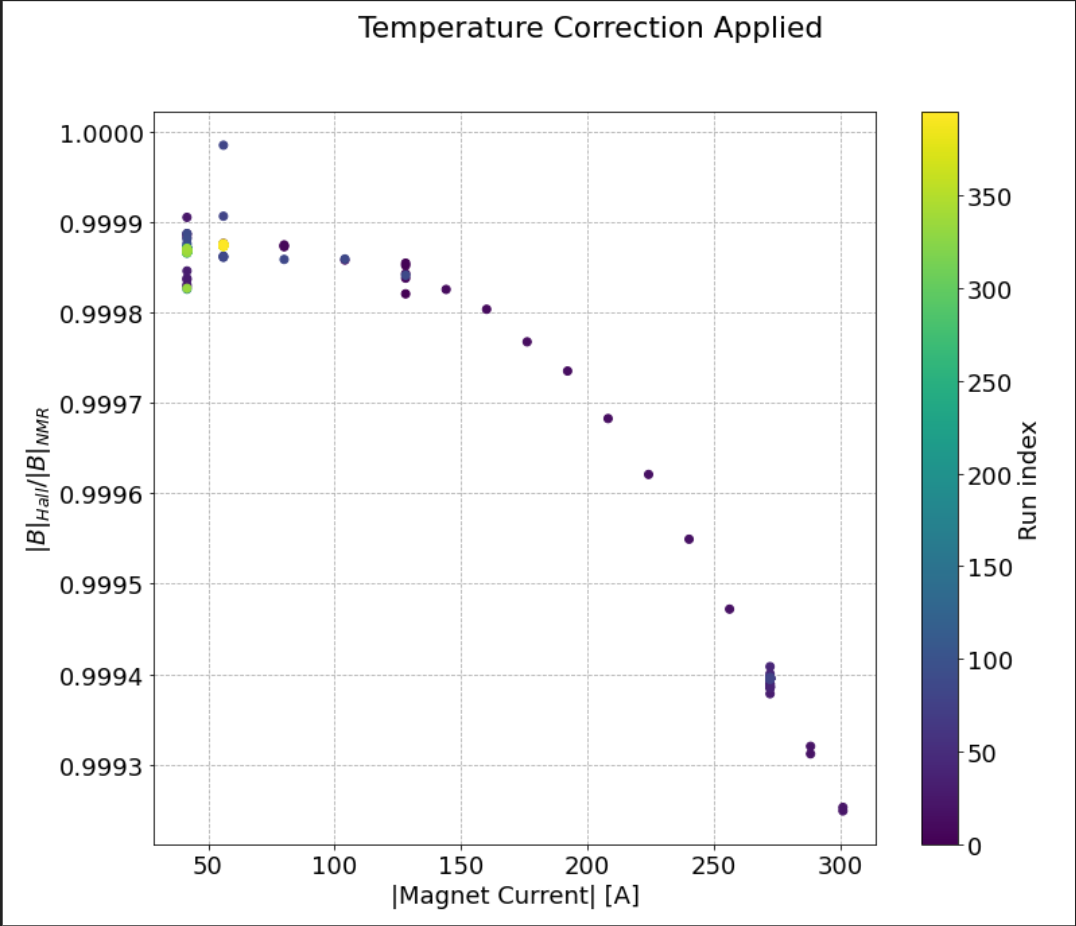

In [ ]:
df_['Magnet Current [A]']

In [ ]:
# FIXME!
# using a fixed value for a quick approximation
BHall_on_BNMR = 0.99976
# BHall_on_BNMR = 0.9998 # test based on NMR not in exact Hall probe location for V vs. B, T
B_Hall_NMR = BHall_on_BNMR * df['NMR [T]'].values

In [ ]:
B_Hall_NMR

In [ ]:
df.loc[:, 'B_Hall_NMR'] = B_Hall_NMR

In [ ]:
(df['B_Hall_NMR'] - df['NMR [T]']).describe()

## Assign better axis labels

In [ ]:
df.loc[:, 'Cal_X'] = df.loc[:, f'{probe}_Cal_Y']
df.loc[:, 'Cal_Y'] = df.loc[:, f'{probe}_Cal_Z']
df.loc[:, 'Cal_Z'] = df.loc[:, f'{probe}_Cal_X']
df.loc[:, 'Cal_Bmag'] = df.loc[:, f'{probe}_Cal_Bmag']
# field angles
df.loc[:, 'Cal_Trans'] = (df.loc[:, 'Cal_X']**2 + df.loc[:, 'Cal_Y']**2)**(1/2)
df.loc[:, 'Cal_Theta'] = np.arctan2(df.loc[:, 'Cal_Trans'], df.loc[:, 'Cal_Bmag'])
df.loc[:, 'Cal_Phi'] = np.arctan2(df.loc[:, 'Cal_Y'], df.loc[:, 'Cal_X'])

In [ ]:
#t0_ = '01-09-23 20:29' # finer scan start
#tf_ = '01-10-23 11:45:10' # magnet tripped during finer scan
t0_ = t0
tf_ = tf
df_ = df.query(f"'{t0_}' <= Datetime <= '{tf_}'").copy()
# df_t_ = df_t.query(f"'{t0_}' <= Datetime <= '{tf_}'").copy()

# remove partial line
#df_ = df_.query('SmarAct_Meas_Angle_1_Centered < -5.3').copy()
#df_ = df_.query('SmarAct_Meas_Angle_1_Centered < 3.4').copy()

In [ ]:
df_.SmarAct_Meas_Angle_1_Centered.round(3).unique()

## Field Strength

In [ ]:
df_.columns

In [ ]:
fig, ax = plt.subplots()

x = (df_[f'{probe}_Cal_Bmag']-df_['B_Hall_NMR'])/df_['B_Hall_NMR']
xmi = np.min(x)
xma = np.max(x)
xra = xma-xmi
bins = np.linspace(xmi-0.05*xra, xma+0.05*xra, 100)

ax.hist(x, histtype='step', bins=bins, label=get_label(x, bins=bins));


ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax.set_xlabel(r'$\frac{|B|_{Hall} - |B|_{NMR}}{|B|_{NMR}}$');
ax.legend(loc='upper left', bbox_to_anchor=(1.0,1.0));

## v1. Reconstruct single coordinate direction (Bz)

### Voltage Function (using same function for calibration orientation)

In [ ]:
'''
def Hall_Cal_B_gen_v1(axis0, axis1, **params):
    Bmax = params['Bmax']
    # calculate normal vectors
    # Hall element is w.r.t. "SmarAct coordinates" (or better, Kinematic plate coordinates) and is fixed, regardless of axis0, axis1
    norm_Hall = np.array([np.sin(params['theta'])*np.cos(params['phi']), np.sin(params['theta'])*np.sin(params['phi']), np.cos(params['theta'])])
    # B field has some nominal orientation w.r.t. kinematic plate, and is further rotated by axis0, axis1
    norm_B = np.array([np.sin(params['alpha'])*np.cos(params['beta']), np.sin(params['alpha'])*np.sin(params['beta']), np.cos(params['alpha'])])
    # rotate the field vector w.r.t.
    #rot = Rotation.from_euler('yz', angles=np.array([-axis0, -axis1]), degrees=False) # ok
    #rot = Rotation.from_euler('yz', angles=np.array([-axis0, -axis1]).T, degrees=False) # ok
    rot = Rotation.from_euler('yz', angles=np.array([-axis0, -axis1]).T, degrees=True) # ok
    norm_B_rot = rot.apply(norm_B)
    # calculate signed fraction of B vector along Hall normal i.e. Hall only reads perpendicular field (to first order)
    frac_B = np.dot(norm_B_rot, norm_Hall)
    B_meas = Bmax * frac_B
    if params['verbose'] == 1.:
        return B_meas, norm_Hall, norm_B, norm_B_rot, frac_B
    else:
        return B_meas
'''
# VECTORIZED
def Hall_Cal_B_gen_v1(axis0, axis1, Bmag, **params):
    if not isinstance(axis0, Iterable):
        axis0 = np.array([axis0])
        axis1 = np.array([axis1])
        Bmag = np.array([Bmag])
    # FIXME! Try passing NMR measurements (adjusted with pole-to-pole) in along with axis0, axis1.
#     Bmax = params['Bmax']
    # calculate normal vectors
    # Hall element is w.r.t. "SmarAct coordinates" (or better, Kinematic plate coordinates) and is fixed, regardless of axis0, axis1
    norm_Hall = np.array([np.sin(params['theta'])*np.cos(params['phi']), np.sin(params['theta'])*np.sin(params['phi']), np.cos(params['theta'])])
    # B field has some nominal orientation w.r.t. kinematic plate, and is further rotated by axis0, axis1
    norm_B = np.array([np.sin(params['alpha'])*np.cos(params['beta']), np.sin(params['alpha'])*np.sin(params['beta']), np.cos(params['alpha'])])
    # rotate the field vector w.r.t.
    #rot = Rotation.from_euler('yz', angles=np.array([-axis0, -axis1]), degrees=False) # ok
    #rot = Rotation.from_euler('yz', angles=np.array([-axis0, -axis1]).T, degrees=False) # ok
    rot = Rotation.from_euler('yz', angles=np.array([-axis0, -axis1]).T, degrees=True) # ok
#     rot = Rotation.from_euler('yz', angles=np.array([-axis0, axis1]).T, degrees=True) # CHECK!
#     rot = Rotation.from_euler('zy', angles=np.array([-axis0, -axis1]).T, degrees=True) # CHECK
    norm_B_rot = rot.apply(np.repeat(norm_B[:, np.newaxis], len(axis0), axis=1).T)
    # calculate signed fraction of B vector along Hall normal i.e. Hall only reads perpendicular field (to first order)
    frac_B = np.dot(norm_B_rot, norm_Hall)
    B_meas = Bmag * frac_B
    if params['verbose'] == 1.:
        return B_meas, norm_Hall, norm_B, norm_B_rot, frac_B
    else:
        return B_meas

In [ ]:
# B aligned perfectly with Kinematic plate
# params = {
#     'Bmax': 1.0, # ~2e6
#     'verbose': 0,
#     'theta': np.radians(2.),
#     #'phi': np.radians(45.),
#     'phi': np.radians(0.),
# #     'phi': np.radians(180.),
#     'alpha': 0.,
#     'beta': 0.
# }

params = {
    'Bmax': 1.0, # ~2e6
    'verbose': 0,
    'theta': np.radians(2.),
    #'phi': np.radians(45.),
    'phi': np.radians(0.),
#     'phi': np.radians(180.),
    'alpha': 0.,
    'beta': np.radians(10.)
}

In [ ]:
ax0s = np.unique(np.round(df_.SmarAct_Meas_Angle_1_Centered, 3))
ax1s = np.unique(np.round(df_.SmarAct_Meas_Angle_2_Centered, 3))
A0, A1 = np.meshgrid(ax0s, ax1s, indexing='ij')

In [ ]:
ax0s

- 2023-01-15 13:03:19 How to handle the fact that the first data point of the second scan is  missing?
    - Ideally, a step of processing should be to set up an ideal grid, and check specifically for each point. Any points that are missing should be inserted as NaNs.

In [ ]:
for ax0 in ax0s:
    line = df_[np.isclose(df_.SmarAct_Meas_Angle_1_Centered, ax0, atol=1e-2, rtol=1e-3)]
    print(f'ax0: {ax0} [deg], N: {len(line)}')

In [ ]:
#Bs = np.array([Hall_Cal_B_gen_v1(a0, a1, **params) for a0, a1 in zip(A0.flatten(), A1.flatten())])
Bs = Hall_Cal_B_gen_v1(A0.flatten(), A1.flatten(), **params)

fig, ax = plt.subplots()
sc = ax.scatter(A0.flatten(), A1.flatten(), c=Bs, s=4);
cb = fig.colorbar(sc, label=r'$B_z$ [T] -- SIMULATED')

ax.set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
ax.set_ylabel('Angle 2 (i.e. Axis 1) [rad]');

In [ ]:
Bs = df_['Cal_Z'].copy().values
# TEMPORARY FIX!!
Bs = np.concatenate([[np.nan], Bs])

fig, ax = plt.subplots()
sc = ax.scatter(A0.flatten(), A1.flatten(), c=Bs, s=4);
cb = fig.colorbar(sc, label=r'$B_z$ [T] -- SIMULATED')

ax.set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
ax.set_ylabel('Angle 2 (i.e. Axis 1) [rad]');

In [ ]:
# B aligned perfectly with Kinematic plate
# does phi change anything, or is it only theta that matters?
phis = np.arange(0., 360., 45.)
# phis = [0., 45., 60., 90., 1]
for phi in phis:
    params = {
        'Bmax': 1.0, # ~2e6
        'verbose': 0,
        'theta': np.radians(2.),
#         'theta': np.pi,
        #'phi': np.radians(45.),
    #     'phi': np.radians(0.),
        'phi': np.radians(phi),
        'alpha': np.radians(-2.),
        'beta': 0.
    }
    ax0s = np.unique(np.round(df_.SmarAct_Meas_Angle_1_Centered, 3))
    ax1s = np.unique(np.round(df_.SmarAct_Meas_Angle_2_Centered, 3))
    A0, A1 = np.meshgrid(ax0s, ax1s, indexing='ij')
    Bs = Hall_Cal_B_gen_v1(A0.flatten(), A1.flatten(), **params)

    fig, ax = plt.subplots()
    sc = ax.scatter(A0.flatten(), A1.flatten(), c=Bs, s=4);
    cb = fig.colorbar(sc, label=r'$B_z$ [T] -- SIMULATED')

    ax.set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
    ax.set_ylabel('Angle 2 (i.e. Axis 1) [rad]')
    
    ax.set_title(rf'$\theta = {params["theta"]:0.3f}, \phi = {params["phi"]:0.3f}$'+'\n'+
                 rf'$\alpha = {params["alpha"]:0.3f}, \beta = {params["beta"]:0.3f}$')

In [ ]:
# B aligned perfectly with Kinematic plate
# theta dependence (phi = 0)
thetas = np.arange(0., 180., 10.)
# phis = [0., 45., 60., 90., 1]
for theta in thetas:
    params = {
        'Bmax': 1.0, # ~2e6
        'verbose': 0,
        'theta': np.radians(theta),
        #'phi': np.radians(45.),
    #     'phi': np.radians(0.),
        'phi': 0.,
        'alpha': 0.,
        'beta': 0.
    }
    ax0s = np.unique(np.round(df_.SmarAct_Meas_Angle_1_Centered, 3))
    ax1s = np.unique(np.round(df_.SmarAct_Meas_Angle_2_Centered, 3))
    A0, A1 = np.meshgrid(ax0s, ax1s, indexing='ij')
#     Bs = np.array([Hall_Cal_B_gen_v1(a0, a1, **params) for a0, a1 in zip(A0.flatten(), A1.flatten())])
    Bs = Hall_Cal_B_gen_v1(A0.flatten(), A1.flatten(), **params)

    fig, ax = plt.subplots()
    sc = ax.scatter(A0.flatten(), A1.flatten(), c=Bs, s=4);
    cb = fig.colorbar(sc, label=r'$B_z$ [T] -- SIMULATED')

    ax.set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
    ax.set_ylabel('Angle 2 (i.e. Axis 1) [rad]')
    
    ax.set_title(rf'$\theta = {params["theta"]:0.3f}, \phi = {params["phi"]:0.3f}$'+'\n'+
                 rf'$\alpha = {params["alpha"]:0.3f}, \beta = {params["beta"]:0.3f}$')

### Fitting

- See if fit for a single Hall element can constrain all four parameters.
- Since we can physically see the Hall elements, SmarAct in the magnet, approximate field direction, we can be smart about initial conditions and limits, if it turns out it there are many minima.
- If it is not possible, may need to combine Hall elements, or combine measurements from different Hall probes (this would be a reason to do a second Hall probe angular scan ASAP).

In [ ]:
ax0s = np.unique(np.round(df_.SmarAct_Meas_Angle_1_Centered, 3))
ax1s = np.unique(np.round(df_.SmarAct_Meas_Angle_2_Centered, 3))
A0, A1 = np.meshgrid(ax0s, ax1s, indexing='ij')

In [ ]:
# generate data, with noise
B0 = 1.0
sigma = 1e-4 #2.8e3
params_true = {
        'Bmax': B0, # ~2e6
        'verbose': 0,
        'theta': np.random.uniform(low=0., high=np.pi),
        #'phi': np.radians(45.),
    #     'phi': np.radians(0.),
        'phi': np.random.uniform(low=-np.pi, high=np.pi),
        'alpha': np.random.uniform(low=0., high=np.radians(12.)),
        'beta': np.random.uniform(low=-np.pi, high=np.pi)
}
#Bs = np.array([Hall_Cal_B_gen_v1(a0, a1, **params_true) for a0, a1 in zip(A0.flatten(), A1.flatten())])
Bs = Hall_Cal_B_gen_v1(A0.flatten(), A1.flatten(), **params)
Bs_meas = Bs + np.random.normal(loc=0, scale=sigma, size=len(Bs)) # ~0.1% noise

In [ ]:
params_true

In [ ]:
Bs, Bs_meas

In [ ]:
fig, ax = plt.subplots()
sc = ax.scatter(A0.flatten(), A1.flatten(), c=Bs, s=4);
cb = fig.colorbar(sc, label=r'$B_z$ [T] -- SIMULATED')

ax.set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
ax.set_ylabel('Angle 2 (i.e. Axis 1) [rad]');

In [ ]:
fig, ax = plt.subplots()
sc = ax.scatter(A0.flatten(), A1.flatten(), c=Bs_meas, s=4);
cb = fig.colorbar(sc, label=r'$B_z$ [T] -- SIMULATED')

ax.set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
ax.set_ylabel('Angle 2 (i.e. Axis 1) [rad]');

In [ ]:
# fit!
model = lm.Model(Hall_Cal_B_gen_v1, independent_vars=['axis0', 'axis1'])
params = lm.Parameters()
# fixed parameters
# params.add('Bmax', value=B0, vary=False)
params.add('Bmax', value=B0, vary=True)
params.add('verbose', value=0., vary=False)
# parameters to vary
params.add('theta', value=np.pi/2, min=0., max=np.pi)
params.add('phi', value=0., min=-np.pi, max=np.pi)
# params.add('alpha', value=np.pi/2, min=0., max=np.pi)
params.add('alpha', value=np.radians(2), min=0., max=np.radians(12.))
params.add('beta', value=0., min=-np.pi, max=np.pi)
# run fit
result = model.fit(Bs_meas, axis0=A0.flatten(), axis1=A1.flatten(),
                   params=params, weights=1/(sigma*np.ones_like(Bs_meas)), scale_covar=False)

In [ ]:
B0

In [ ]:
result

In [ ]:
params_true

### Fit on real data!

In [ ]:
B0 = df[f'Cal_Z'].abs().max()

In [ ]:
B0

In [ ]:
sigma_est = 3e-5
#sigma_est = 1e-4
# sigma_est = 1e-3
coord = 'Z'
# coord = 'X'
# coord = 'Y'
B0 = df[f'Cal_{coord}'].abs().max()
Bs_meas = df[f'Cal_{coord}'].values
# fit!
model = lm.Model(Hall_Cal_B_gen_v1, independent_vars=['axis0', 'axis1', 'Bmag'])
params = lm.Parameters()
# fixed parameters
#params.add('Bmax', value=B0, vary=True)
# params.add('Bmax', value=1.00212872, vary=False)
params.add('verbose', value=0., vary=False)
# parameters to vary
# params.add('theta', value=np.pi/2, min=0. - np.pi/4, max=np.pi + np.pi/4)
# params.add('theta', value=np.pi/2, min=0., max=np.pi + np.pi/4) # GOOD
params.add('theta', value=0.01475871, vary=False)
# params.add('theta', value=0.02, min=0., max=np.pi + np.pi/4) # based on previous scans
# params.add('phi', value=0., min=-np.pi, max=np.pi) # GOOD
params.add('phi', value=3.06398294, vary=False)
## TURN OFF THETA / PHI (Hall orientation on the plate)
# params.add('theta', value=0., vary=True)
# params.add('phi', value=0., vary=False)
# params.add('alpha', value=np.pi/2, min=0., max=np.pi)
# params.add('alpha', value=np.radians(2), min=np.radians(-4.), max=np.radians(12.))
# params.add('alpha', value=np.radians(2), min=0., max=np.radians(12.)) # GOOD
params.add('alpha', value=0.03490732, vary=False) # GOOD
# params.add('beta', value=0., min=-np.pi - np.pi/4, max=np.pi + np.pi/4, vary=True)
# params.add('beta', value=3.0, min=-np.pi, max=np.pi, vary=True)
#params.add('beta', value=np.pi, min=0., max=2*np.pi, vary=True) # GOOD
params.add('beta', value=2.74794549, vary=False) # GOOD
# best fit alpha and beta
# params.add('alpha', value=0.03240273, vary=False)
# params.add('beta', value=-3.14159265, vary=False)

### NOT SURE THAT THESE WORK ON THEIR OWN
# phi for X (really Y)
# if coord == 'X':
#     params.add('phi', value=-np.pi/2, vary=True, min=-np.pi/2 + np.radians(-10), max=-np.pi/2 + np.radians(10))
# phi for Y (really X)
# if coord == 'Y':
#     params.add('phi', value=0., vary=True, min=np.radians(-10), max=np.radians(10))

# run fit
#result = model.fit(Bs_meas, axis0=A0.flatten(), axis1=A1.flatten(),
#                   params=params, weights=1/(sigma_est*B0*np.ones_like(Bs_meas)), scale_covar=False)
###
# result = model.fit(Bs_meas, axis0=df['SmarAct_Meas_Angle_1_Centered'].values, axis1=df['SmarAct_Meas_Angle_2_Centered'].values,
#                   params=params, weights=1/(sigma_est*B0*np.ones_like(Bs_meas)), scale_covar=False)
# add Bmag
result = model.fit(Bs_meas, axis0=df['SmarAct_Meas_Angle_1_Centered'].values, axis1=df['SmarAct_Meas_Angle_2_Centered'].values,
                   Bmag=df[f'{probe}_Cal_Bmag'].values,
                   params=params, weights=1/(sigma_est*B0*np.ones_like(Bs_meas)), scale_covar=False)
result_Zcoord = result

In [ ]:
632 / 14644

In [ ]:
B0

In [ ]:
# scan 5 (incomplete)
# only can get a good fit result if I fix alpha/beta to be the best fit values (used scan 3 values)
result_Zcoord

In [ ]:
# scan 4
result_Zcoord

In [ ]:
# scan 3
result_Zcoord

In [ ]:
-3.5352 + 2*np.pi

In [ ]:
# scan 2
result

In [ ]:
np.degrees(0.011)

In [ ]:
def normalize_angle(angle, degrees=False):
    if degrees:
        angle_rad = np.radians(angle)
        return np.degrees(np.arctan2(np.sin(angle_rad), np.cos(angle_rad)))
    else:
        return np.arctan2(np.sin(angle), np.cos(angle))

def normalize_polar_angle(angle, degrees=False):
    if degrees:
        angle_rad = np.radians(angle)
        return np.degrees(np.arccos(np.cos(angle_rad)))
    else:
        return np.arccos(np.cos(angle))

In [ ]:
for k in result.params.keys():
    print(k, result.params[k].value, normalize_angle(result.params[k].value), normalize_polar_angle(result.params[k].value))

In [ ]:
if not np.isclose(normalize_angle(result.params['theta'].value), normalize_polar_angle(result.params['theta'].value)):
    print('Phi flipped')
    print(f'Phi0: {result.params["phi"].value}, Phi0 + pi: {normalize_angle(result.params["phi"].value+np.pi)}')

In [ ]:
if not np.isclose(normalize_angle(result.params['alpha'].value), normalize_polar_angle(result.params['alpha'].value)):
    print('Beta flipped')
    print(f'Beta0: {result.params["beta"].value}, Beta0 + pi: {normalize_angle(result.params["beta"].value+np.pi)}')

In [ ]:
np.degrees(result.params['theta'])

In [ ]:
np.degrees(result.params['phi'])

In [ ]:
np.degrees(result.params['alpha'])

In [ ]:
np.degrees(result.params['beta'])

In [ ]:
result.best_fit

In [ ]:
# plots!
from matplotlib.colors import Normalize
import matplotlib.cm as cm

In [ ]:
Bmin = np.min([np.min(df[f'Cal_{coord}']), np.min(result.best_fit)])
Bmax = np.max([np.max(df[f'Cal_{coord}']), np.max(result.best_fit)])

In [ ]:
Bmin, Bmax

In [ ]:
# data, fit
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(Bmin, Bmax)
im = cm.ScalarMappable(norm=normalizer)
# sc = axs[0].scatter(A0.flatten(), A1.flatten(), c=Bs_meas, s=4, cmap=cmap, norm=normalizer)
# sc1 = axs[1].scatter(A0.flatten(), A1.flatten(), c=result.best_fit, s=4, cmap=cmap, norm=normalizer)

sc = axs[0].scatter(df['SmarAct_Meas_Angle_1_Centered'].values, df['SmarAct_Meas_Angle_2_Centered'].values, c=Bs_meas, s=4, cmap=cmap, norm=normalizer)
sc1 = axs[1].scatter(df['SmarAct_Meas_Angle_1_Centered'].values, df['SmarAct_Meas_Angle_2_Centered'].values, c=result.best_fit, s=4, cmap=cmap, norm=normalizer)

cb = fig.colorbar(im, label=r'$B_z$ [T]')

axs[0].set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
axs[0].set_ylabel('Angle 2 (i.e. Axis 1) [rad]')
axs[0].set_title('Measured Values')
axs[1].set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
axs[1].set_ylabel('Angle 2 (i.e. Axis 1) [rad]')
axs[1].set_title('Best Fit Values: \n'+
                 rf'$\theta = {result.params["theta"].value:0.3f},\ \phi = {result.params["phi"].value:0.3f}$, '+#'\n'+
                 rf'$\alpha = {result.params["alpha"].value:0.3f},\ \beta = {result.params["beta"].value:0.3f}$')

In [ ]:
# data - fit
fig, ax = plt.subplots(figsize=(12, 8))
cmap = cm.get_cmap('viridis')
# normalizer = Normalize(Bmin, Bmax)
# im = cm.ScalarMappable(norm=normalizer)
# sc = axs[0].scatter(A0.flatten(), A1.flatten(), c=Bs_meas, s=4, cmap=cmap, norm=normalizer)
# sc1 = axs[1].scatter(A0.flatten(), A1.flatten(), c=result.best_fit, s=4, cmap=cmap, norm=normalizer)

sc = ax.scatter(df['SmarAct_Meas_Angle_1_Centered'].values, df['SmarAct_Meas_Angle_2_Centered'].values, c=Bs_meas-result.best_fit, s=4, cmap=cmap)#, norm=normalizer)

cb = fig.colorbar(sc, label=rf'$B_{coord}$ [T]')

ax.set_xlabel('Angle 1 (i.e. Axis 0) [deg]')
ax.set_ylabel('Angle 2 (i.e. Axis 1) [deg]')
ax.set_title('Measured Values - Best Fit Values: \n'+
             rf'$\theta = {result.params["theta"].value:0.3f},\ \phi = {result.params["phi"].value:0.3f}$, '+#'\n'+
             rf'$\alpha = {result.params["alpha"].value:0.3f},\ \beta = {result.params["beta"].value:0.3f}$')

In [ ]:
# hist
fig, ax = plt.subplots()

bins = np.arange(-1.50e-4, 1.52e-4, 2e-6)
# bins = np.arange(-5.0e-5, 5.05e-5, 5e-7) # for good scans
# bins = np.arange(-5.0e-3, 5.05e-3, 5e-5) # wide search for large residuals

ax.hist(Bs_meas-result.best_fit, bins=bins, histtype='step', label=get_label(Bs_meas-result.best_fit, bins))

ax.set_xlabel(rf'Data - Fit, $B_{coord}$ [T]')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1.0));

In [ ]:
# residual vs time
fig, ax = plt.subplots()

#bins = np.arange(-1.50e-4, 1.52e-4, 2e-6)
# bins = np.arange(-5.0e-5, 5.05e-5, 5e-7) # for good scans
# bins = np.arange(-5.0e-3, 5.05e-3, 5e-5) # for good scans

ax.scatter(df.index, Bs_meas-result.best_fit)

ax.set_xlabel('Datetime')
ax.set_ylabel(rf'Data - Fit, $B_{coord}$ [T]')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0));
# ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1.0));

In [ ]:
# how about transverse field?
#BT_fit = (result_Zcoord.params['Bmax'].value**2 - result_Zcoord.best_fit**2)**(1/2)
BT_fit = (df[f'{probe}_Cal_Bmag'].values**2 - result_Zcoord.best_fit**2)**(1/2)
BT_meas = np.linalg.norm(df[['Cal_X', 'Cal_Y']].values, axis=1)

In [ ]:
# data - fit
fig, ax = plt.subplots(figsize=(12, 8))
cmap = cm.get_cmap('viridis')
# normalizer = Normalize(Bmin, Bmax)
# im = cm.ScalarMappable(norm=normalizer)
# sc = axs[0].scatter(A0.flatten(), A1.flatten(), c=Bs_meas, s=4, cmap=cmap, norm=normalizer)
# sc1 = axs[1].scatter(A0.flatten(), A1.flatten(), c=result.best_fit, s=4, cmap=cmap, norm=normalizer)

sc = ax.scatter(df['SmarAct_Meas_Angle_1_Centered'].values, df['SmarAct_Meas_Angle_2_Centered'].values, c=BT_meas-BT_fit, s=4, cmap=cmap)#, norm=normalizer)

cb = fig.colorbar(sc, label=r'$\Delta B_{T}$ [T]')

ax.set_xlabel('Angle 1 (i.e. Axis 0) [deg]')
ax.set_ylabel('Angle 2 (i.e. Axis 1) [deg]')
ax.set_title('Measured Values - Best Fit Values: \n'+
             rf'$\theta = {result.params["theta"].value:0.3f},\ \phi = {result.params["phi"].value:0.3f}$, '+#'\n'+
             rf'$\alpha = {result.params["alpha"].value:0.3f},\ \beta = {result.params["beta"].value:0.3f}$')

In [ ]:
# hist
fig, ax = plt.subplots()

# bins = np.arange(-1.50e-4, 1.52e-4, 2e-6)
bins = np.arange(-1.50e-3, 1.52e-3, 2e-5)

ax.hist(BT_meas-BT_fit, bins=bins, histtype='step', label=get_label(BT_meas-BT_fit, bins))

ax.set_xlabel(r'Data - Fit, $B_{T}$ [T]')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1.0));

In [ ]:
BT_meas

In [ ]:
BT_fit

In [ ]:
df[['Cal_X', 'Cal_Y']].values.shape

In [ ]:
BT_fit

- I think I need to go from here... 2023-01-15 13:15:40 
    - Next step is probably getting theta / phi from SmarAct angles.
    - Or looking at other fitting metrics

In [ ]:
### BELOW ISN'T USEFUL, I THINK

In [ ]:
# Bergsma fit
fig, ax = plt.subplots()

ax.scatter(df['NMR [T]'], df[f'{probe}_Cal_Bmag'], s=1)

In [ ]:
# Bergsma fit
fig, ax = plt.subplots()

ax.scatter(df.index, df[f'{probe}_Cal_Bmag']-df['NMR [T]'], s=1)

In [ ]:
fig, ax = plt.subplots()

ax.hist((df[f'{probe}_Cal_Bmag']-df['NMR [T]'])/df['NMR [T]'], histtype='step', bins=100);

In [ ]:
res_rel = (df[f'{probe}_Cal_Bmag']-df['NMR [T]'])/df['NMR [T]']
res_rel.mean(), res_rel.std()

In [ ]:
# check NMR and temp stability
for col in ['NMR [T]', f'{probe}_Cal_T']:
    fig, ax = plt.subplots()
    sc = ax.scatter(A0.flatten(), A1.flatten(), c=df[col], s=4);
    cb = fig.colorbar(sc, label=col)

    ax.set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
    ax.set_ylabel('Angle 2 (i.e. Axis 1) [rad]');

In [ ]:
result.params['theta'].value

In [ ]:
# data - fit
fig, ax = plt.subplots()
sc = ax.scatter(a1, a2, c=Bs_meas - result.best_fit, s=4);
cb = fig.colorbar(sc, label=r'$B_z$ [T]')

ax.set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
ax.set_ylabel('Angle 2 (i.e. Axis 1) [rad]')
ax.set_title('Data - Fit');

In [ ]:
# data / fit
fig, ax = plt.subplots()
sc = ax.scatter(a1, a2, c=Bs_meas / result.best_fit, s=4);
cb = fig.colorbar(sc, label=r'$B_{z, meas.} / B_{z, fit}$')

ax.set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
ax.set_ylabel('Angle 2 (i.e. Axis 1) [rad]')
ax.set_title('Data / Fit');

In [ ]:
# histograms

In [ ]:
len(Bs_meas)

In [ ]:
fig, ax = plt.subplots()

ax.hist(Bs_meas - result.best_fit, bins=100, histtype='step')

ax.set_xlabel(r'Data - Fit [T]')

In [ ]:
np.mean(Bs_meas - result.best_fit), np.std(Bs_meas - result.bes.t_fit, ddof=1)

In [ ]:
fig, ax = plt.subplots()

ax.hist(Bs_meas / result.best_fit, bins=100, histtype='step')

ax.set_xlabel(r'Data / Fit')

In [ ]:
np.mean(Bs_meas / result.best_fit), np.std(Bs_meas / result.best_fit, ddof=1)

## v2. Reconstruct all coordinates at once

### Voltage Function (using same function for calibration orientation)

In [ ]:
'''
def Hall_Cal_B_gen_v2(axis0, axis1, **params):
    if not isinstance(axis0, Iterable):
        axis0 = np.array([axis0])
        axis1 = np.array([axis1])
    # FIXME! Try passing NMR measurements (adjusted with pole-to-pole) in along with axis0, axis1.
    Bmax = params['Bmax']
    # calculate normal vectors
    # Hall element is w.r.t. "SmarAct coordinates" (or better, Kinematic plate coordinates) and is fixed, regardless of axis0, axis1
    norm_Hall = np.array([np.sin(params['theta'])*np.cos(params['phi']), np.sin(params['theta'])*np.sin(params['phi']), np.cos(params['theta'])])
    # B field has some nominal orientation w.r.t. kinematic plate, and is further rotated by axis0, axis1
    norm_B = np.array([np.sin(params['alpha'])*np.cos(params['beta']), np.sin(params['alpha'])*np.sin(params['beta']), np.cos(params['alpha'])])
    # rotate the field vector w.r.t.
    #rot = Rotation.from_euler('yz', angles=np.array([-axis0, -axis1]), degrees=False) # ok
    #rot = Rotation.from_euler('yz', angles=np.array([-axis0, -axis1]).T, degrees=False) # ok
    rot = Rotation.from_euler('yz', angles=np.array([-axis0, -axis1]).T, degrees=True) # ok
#     rot = Rotation.from_euler('zy', angles=np.array([-axis0, -axis1]).T, degrees=True) # CHECK
    norm_B_rot = rot.apply(np.repeat(norm_B[:, np.newaxis], len(axis0), axis=1).T)
    # calculate signed fraction of B vector along Hall normal i.e. Hall only reads perpendicular field (to first order)
    costh = np.dot(norm_B_rot, norm_Hall)
    #sinth = np.sin(np.arccos(costh))
    B_T = np.linalg.norm(norm_B_rot[:,:2], axis=1)
    theta = np.arctan2(B_T, norm_B_rot[:,2])
    phi = np.arctan2(norm_B_rot[:, 1], norm_B_rot[:, 0]) + params['phase']
    Bx = Bmax * np.sin(theta) * np.cos(phi)
    By = Bmax * np.sin(theta) * np.sin(phi)
    Bz = Bmax * np.cos(theta)
#     print(Bx, By, Bz)
#     try:
    B_meas = np.concatenate([Bx, By, Bz])
#     except:
#         B_meas = np.array([Bx, By, Bz])
    if params['verbose'] == 1.:
        return B_meas, norm_Hall, norm_B, norm_B_rot, theta, phi
    else:
        return B_meas
'''

'''
# rotate Bvector into Hall probe frame
def rodrigues_rotation(points, vec0, vec1):
    # points should be N x 3
    # rotate from vec0 to vec1
    # note vec0 and vec1 should be normalized
    k_vec = np.cross(vec0, vec1)
    k_vec = k_vec / np.linalg.norm(k_vec)
    costheta = np.dot(vec0, vec1)
    sintheta = (1-costheta**2)**(1/2)
    points_rot = points * costheta + np.cross(k_vec, points) * sintheta + np.outer(np.dot(points, k_vec), k_vec) * (1 - costheta)
    return points_rot
'''

def Hall_Cal_B_gen_v2(axis0, axis1, Bmag, **params):
    if not isinstance(axis0, Iterable):
        axis0 = np.array([axis0])
        axis1 = np.array([axis1])
        Bmag = np.array([Bmag])
    # FIXME! Try passing NMR measurements (adjusted with pole-to-pole) in along with axis0, axis1.
#     Bmax = params['Bmax']
    # calculate normal vectors
    # Hall element is w.r.t. "SmarAct coordinates" (or better, Kinematic plate coordinates) and is fixed, regardless of axis0, axis1
    norm_Hall = np.array([np.sin(params['theta'])*np.cos(params['phi']), np.sin(params['theta'])*np.sin(params['phi']), np.cos(params['theta'])])
    # x_Hall is arbitary...
    x_Hall = np.array([-np.sin(params['phi']), np.cos(params['phi']), 0.])
    # B field has some nominal orientation w.r.t. kinematic plate, and is further rotated by axis0, axis1
    norm_B = np.array([np.sin(params['alpha'])*np.cos(params['beta']), np.sin(params['alpha'])*np.sin(params['beta']), np.cos(params['alpha'])])
    # rotate the field vector w.r.t.
    #rot = Rotation.from_euler('yz', angles=np.array([-axis0, -axis1]), degrees=False) # ok
    #rot = Rotation.from_euler('yz', angles=np.array([-axis0, -axis1]).T, degrees=False) # ok
    rot = Rotation.from_euler('yz', angles=np.array([-axis0, -axis1]).T, degrees=True) # ok
#     rot = Rotation.from_euler('yz', angles=np.array([-axis0, axis1]).T, degrees=True) # CHECK!
    norm_B_rot = rot.apply(np.repeat(norm_B[:, np.newaxis], len(axis0), axis=1).T)
    # calculate signed fraction of B vector along Hall normal i.e. Hall only reads perpendicular field (to first order)
    costh = np.dot(norm_B_rot, norm_Hall)
    sinth = (1 - costh**2)**(1/2)
    theta = np.arccos(costh)
    BT_rot90 = np.cross(norm_B_rot, norm_Hall)
    BT_rot90 = BT_rot90 / np.linalg.norm(BT_rot90, axis=1)[:, None]
    BT_rot = np.cross(norm_Hall, BT_rot90)
#     BT_rot = np.cross(norm_B_rot, norm_Hall)
    # must normalize BT_rot
    BT_rot = BT_rot / np.linalg.norm(BT_rot, axis=1)[:, None]
#     phi_Hall = np.arccos(np.dot(BT_rot, x_Hall)) + params['phase']
    phi_Hall = np.arccos(np.dot(BT_rot, x_Hall))
    sign_phi = 2*(np.dot(np.cross(x_Hall, BT_rot), norm_Hall) > 0.).astype(int) - 1.
#     sign_phi = 2*(np.dot(np.cross(x_Hall, BT_rot), norm_Hall) < 0.).astype(int) - 1.
#     phi_Hall = sign_phi * phi_Hall
    phi_Hall = sign_phi * phi_Hall + params['phase']
    # recenter phi
    phi_Hall[phi_Hall > np.pi] = phi_Hall[phi_Hall > np.pi] - 2*np.pi
    phi_Hall[phi_Hall < -np.pi] = phi_Hall[phi_Hall < -np.pi] + 2*np.pi
    ###
    Bx = Bmag * sinth * np.cos(phi_Hall)
    By = Bmag * sinth * np.sin(phi_Hall)
    Bz = Bmag * costh
    B_meas = np.concatenate([Bx, By, Bz])
    if params['verbose'] == 1.:
        return B_meas, norm_Hall, norm_B, norm_B_rot, BT_rot, theta, phi_Hall
    else:
        return B_meas

### Test

In [ ]:
params= {'theta': np.radians(15.), 'phi': np.radians(-5.)}
norm_Hall = np.array([np.sin(params['theta'])*np.cos(params['phi']), np.sin(params['theta'])*np.sin(params['phi']), np.cos(params['theta'])])
# x_Hall is arbitary...
x_Hall = np.array([-np.sin(params['phi']), np.cos(params['phi']), 0.])

In [ ]:
norm_Hall, x_Hall

In [ ]:
np.dot(norm_Hall, x_Hall)

In [ ]:
params= {'theta': np.radians(15.), 'phi': np.radians(-5.)}
norm_Hall = np.array([np.sin(params['theta'])*np.cos(params['phi']), np.sin(params['theta'])*np.sin(params['phi']), np.cos(params['theta'])])
norm_B_rot = np.array([[0, 1, 2], [3, 4, 5], [6, 7,8], [9, 10, 11]])

In [ ]:
norm_B_rot, norm_Hall

In [ ]:
np.cross(norm_B_rot, norm_Hall)

In [ ]:
np.cross(norm_B_rot[3], norm_Hall)

In [ ]:
np.cross(norm_Hall, np.cross(norm_B_rot, norm_Hall))

In [ ]:
np.cross(norm_Hall, np.cross(norm_B_rot[3], norm_Hall))

In [ ]:
np.dot(norm_B_rot, norm_Hall)

In [ ]:
np.dot(norm_B_rot[3], norm_Hall)

In [ ]:
phi

In [ ]:
np.ptp(phi)

### Fitting

- See if fit works to constrain all five parameters.

In [ ]:
ax0s = np.unique(np.round(df_.SmarAct_Meas_Angle_1_Centered, 3))
ax1s = np.unique(np.round(df_.SmarAct_Meas_Angle_2_Centered, 3))
A0, A1 = np.meshgrid(ax0s, ax1s, indexing='ij')

In [ ]:
ax0s

In [ ]:
# generate data, with noise
B0 = 1.0
sigma = 3e-5
params_true = {
        'Bmax': B0, # ~2e6
        'verbose': 1,
        #'theta': np.random.uniform(low=0., high=np.pi),
        'theta': np.random.uniform(low=0., high=np.pi/8.),
        #'phi': np.radians(45.),
    #     'phi': np.radians(0.),
        'phi': np.random.uniform(low=-np.pi, high=np.pi),
        #'alpha': np.random.uniform(low=0., high=np.radians(12.)),
        'alpha': np.random.uniform(low=0., high=np.pi/8.),
        'beta': np.random.uniform(low=-np.pi, high=np.pi),
        'phase': np.random.uniform(low=-np.pi, high=np.pi)
}
Bmags = B0 * np.ones_like(A0.flatten())


#Bs = np.array([Hall_Cal_B_gen_v2(a0, a1, **params_true) for a0, a1 in zip(A0.flatten(), A1.flatten())])
# Bs = Hall_Cal_B_gen_v2(A0.flatten(), A1.flatten(), **params_true)
Bs, norm_Hall, norm_B, norm_B_rot, BT_rot, theta, phi = Hall_Cal_B_gen_v2(A0.flatten(), A1.flatten(), Bmags, **params_true)
Bs_meas = Bs + np.random.normal(loc=0, scale=sigma, size=Bs.shape) # ~0.1% noise

N = len(A0.flatten())
Bxs = Bs[:N]
Bys = Bs[N:2*N]
Bzs = Bs[2*N:]

Bxs_meas = Bs_meas[:N]
Bys_meas = Bs_meas[N:2*N]
Bzs_meas = Bs_meas[2*N:]

In [ ]:
np.linalg.norm(BT_rot, axis=1)

In [ ]:
np.linalg.norm(norm_B_rot, axis=1)

In [ ]:
np.linalg.norm(norm_B_rot, axis=1)

In [ ]:
norm_Hall = np.array([np.sin(params['theta'])*np.cos(params['phi']), np.sin(params['theta'])*np.sin(params['phi']), np.cos(params['theta'])])

In [ ]:
np.linalg.norm(norm_Hall)

In [ ]:
np.linalg.norm(np.cross(norm_B_rot, norm_Hall), axis=1)

In [ ]:
np.ptp(phi)

In [ ]:
np.pi*2

In [ ]:
theta

In [ ]:
params_true

In [ ]:
Bs, Bs_meas

In [ ]:
for Bs_, l in zip([Bxs, Bys, Bzs], ['x', 'y', 'z']):
    fig, ax = plt.subplots()
    sc = ax.scatter(A0.flatten(), A1.flatten(), c=Bs_, s=4);
    cb = fig.colorbar(sc, label=rf'$B_{l}$ [T] -- SIMULATED')

    ax.set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
    ax.set_ylabel('Angle 2 (i.e. Axis 1) [rad]');

In [ ]:
# fit!
model = lm.Model(Hall_Cal_B_gen_v2, independent_vars=['axis0', 'axis1'])
params = lm.Parameters()
# fixed parameters
# params.add('Bmax', value=B0, vary=False)
params.add('Bmax', value=B0, vary=True)
params.add('verbose', value=0., vary=False)
# parameters to vary
params.add('theta', value=np.pi/2, min=0., max=np.pi)
params.add('phi', value=0., min=-np.pi, max=np.pi)
# params.add('alpha', value=np.pi/2, min=0., max=np.pi)
params.add('alpha', value=np.radians(2), min=0., max=np.radians(12.))
params.add('beta', value=0., min=-np.pi, max=np.pi)
params.add('phase', value=0., min=-np.pi, max=np.pi)
# run fit
result = model.fit(Bs_meas, axis0=A0.flatten(), axis1=A1.flatten(),
                   params=params, weights=1/(sigma*np.ones_like(Bs_meas)), scale_covar=False)

In [ ]:
B0

In [ ]:
result

In [ ]:
params_true

### Fit on real data!

In [ ]:
df

In [ ]:
# do we query a particular run?
# df_ = df.copy() # no
df_ = df.query('"01-16-23 08:55" <= Datetime <= "01-18-23 15:25"').copy() # yes, query run 3.
#df_ = df.query('("01-16-23 08:55" <= Datetime <= "01-18-23 15:25") or ("01-22-23 06:37" <= Datetime)').copy() # yes, query run 3 and 5
# df_ = df.query('("01-16-23 08:55" <= Datetime <= "01-18-23 15:25") or ("01-22-23 06:37" >= Datetime)').copy() # yes, query run 3 and 4

In [ ]:
sigma_est = 3e-5
# sigma_est = 1e-4
# sigma_est = 1e-3
# coord = 'Z'
# coord = 'X'
# coord = 'Y'
#B0 = df[f'Cal_{coord}'].abs().max()
B0 = df_['B_Hall_NMR'].mean()
Bs_meas = np.concatenate([df_[f'Cal_{coord}'].values for coord in ['X', 'Y', 'Z']])
# fit!
model = lm.Model(Hall_Cal_B_gen_v2, independent_vars=['axis0', 'axis1', 'Bmag'])
params = lm.Parameters()
# '''
# fixed parameters
# params.add('Bmax', value=B0, vary=True, min=0.5, max=1.5)
# params.add('Bmax', value=B0, vary=False)
# params.add('Bmax', value=1.00212872, vary=False)
params.add('verbose', value=0., vary=False)
# parameters to vary
# params.add('theta', value=np.pi/2, min=0. - np.pi/4, max=np.pi + np.pi/4)
params.add('theta', value=np.radians(2), min=0., max=np.radians(5.))
params.add('phi', value=0., min=-np.pi, max=np.pi)
# params.add('alpha', value=np.pi/2, min=0., max=np.pi)
# params.add('alpha', value=np.radians(2), min=np.radians(-4.), max=np.radians(12.))
params.add('alpha', value=np.radians(2), min=0., max=np.radians(5.))
# params.add('alpha', value=-0.03523667, vary=False)
# params.add('beta', value=0., min=-np.pi - np.pi/4, max=np.pi + np.pi/4, vary=True)
# params.add('beta', value=0., min=-np.pi, max=np.pi, vary=True)
params.add('beta', value=np.pi, min=0., max=2*np.pi, vary=True)
# params.add('beta', value=-0.40267806, vary=False,)
params.add('phase', value=0., min=-np.pi, max=np.pi)
# best fit alpha and beta
# params.add('alpha', value=0.03240273, vary=False)
# params.add('beta', value=-3.14159265, vary=False)
# '''

'''
# var = False
var = True
params.add('verbose', value=0., vary=False)
# params.add('Bmax', value=result_Zcoord.params['Bmax'].value, vary = False)
params.add('theta', value=result_Zcoord.params['theta'].value, vary = var)
params.add('phi', value=result_Zcoord.params['phi'].value, vary = var)
params.add('alpha', value=result_Zcoord.params['alpha'].value, vary = var)
params.add('beta', value=result_Zcoord.params['beta'].value, vary = var)
params.add('phase', value=0., min=-np.pi, max=np.pi, vary=var)
'''

### NOT SURE THAT THESE WORK ON THEIR OWN
# phi for X (really Y)
# if coord == 'X':
#     params.add('phi', value=-np.pi/2, vary=True, min=-np.pi/2 + np.radians(-10), max=-np.pi/2 + np.radians(10))
# phi for Y (really X)
# if coord == 'Y':
#     params.add('phi', value=0., vary=True, min=np.radians(-10), max=np.radians(10))

# run fit
#result = model.fit(Bs_meas, axis0=A0.flatten(), axis1=A1.flatten(),
#                   params=params, weights=1/(sigma_est*B0*np.ones_like(Bs_meas)), scale_covar=False)
####
# result = model.fit(Bs_meas, axis0=df['SmarAct_Meas_Angle_1_Centered'].values, axis1=df['SmarAct_Meas_Angle_2_Centered'].values,
#                   params=params, weights=1/(sigma_est*B0*np.ones_like(Bs_meas)), scale_covar=False)
# adding Bmag
result = model.fit(Bs_meas, axis0=df_['SmarAct_Meas_Angle_1_Centered'].values, axis1=df_['SmarAct_Meas_Angle_2_Centered'].values,
                   Bmag=df_[f'{probe}_Cal_Bmag'].values, params=params, weights=1/(sigma_est*B0*np.ones_like(Bs_meas)), scale_covar=False)

In [ ]:
# scan 3 fit
result

In [ ]:
# scan 3-5 simulataneous fit
result

In [ ]:
# scan 3 & 4 simulataneous fit
result

In [ ]:
# scan 3 & 5 simulataneous fit
result

In [ ]:
# scan 3-5 simulataneous fit
result

In [ ]:
# old scan
result

In [ ]:
# scan 3-5 simulataneous fit
# query only scan 3.
result

In [ ]:
# scan 3-5 simulataneous fit
result

In [ ]:
# scan 5 (incomplete)
result

In [ ]:
# scan 4
result

In [ ]:
# scan 3
result

In [ ]:
np.sin(result.params['theta']) * np.cos(result.params['phi']), np.sin(result.params['theta']) * np.sin(result.params['phi']), np.cos(result.params['theta'])

In [ ]:
np.degrees(1.07236) + 180

In [ ]:
result_Zcoord

In [ ]:
np.degrees(0.011)

In [ ]:
def normalize_angle(angle, degrees=False):
    if degrees:
        angle_rad = np.radians(angle)
        return np.degrees(np.arctan2(np.sin(angle_rad), np.cos(angle_rad)))
    else:
        return np.arctan2(np.sin(angle), np.cos(angle))

def normalize_polar_angle(angle, degrees=False):
    if degrees:
        angle_rad = np.radians(angle)
        return np.degrees(np.arccos(np.cos(angle_rad)))
    else:
        return np.arccos(np.cos(angle))

In [ ]:
for k in result.params.keys():
    print(k, result.params[k].value, normalize_angle(result.params[k].value), normalize_polar_angle(result.params[k].value))

In [ ]:
if not np.isclose(normalize_angle(result.params['theta'].value), normalize_polar_angle(result.params['theta'].value)):
    print('Phi flipped')
    print(f'Phi0: {result.params["phi"].value}, Phi0 + pi: {normalize_angle(result.params["phi"].value+np.pi)}')

In [ ]:
if not np.isclose(normalize_angle(result.params['alpha'].value), normalize_polar_angle(result.params['alpha'].value)):
    print('Beta flipped')
    print(f'Beta0: {result.params["beta"].value}, Beta0 + pi: {normalize_angle(result.params["beta"].value+np.pi)}')

In [ ]:
np.degrees(result.params['theta'])

In [ ]:
np.degrees(result.params['phi'])

In [ ]:
np.degrees(result.params['alpha'])

In [ ]:
np.degrees(result.params['beta'])

In [ ]:
result.best_fit

In [ ]:
# plots!
from matplotlib.colors import Normalize
import matplotlib.cm as cm

In [ ]:
#N = len(df)
N = len(df_)
### X
# coord = 'X'
# ind0 = 0
# ind1 = 1*N
### Y
coord = 'Y'
ind0 = 1*N
ind1 = 2*N
### Z
# coord = 'Z'
# ind0 = 2*N
# ind1 = 3*N
####
bf = result.best_fit[ind0:ind1]

Bmin = np.min([np.min(df[f'Cal_{coord}']), np.min(bf)])
Bmax = np.max([np.max(df[f'Cal_{coord}']), np.max(bf)])

In [ ]:
Bmin, Bmax

In [ ]:
# data, fit
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(Bmin, Bmax)
im = cm.ScalarMappable(norm=normalizer)
# sc = axs[0].scatter(A0.flatten(), A1.flatten(), c=Bs_meas, s=4, cmap=cmap, norm=normalizer)
# sc1 = axs[1].scatter(A0.flatten(), A1.flatten(), c=result.best_fit, s=4, cmap=cmap, norm=normalizer)

sc = axs[0].scatter(df_['SmarAct_Meas_Angle_1_Centered'].values, df_['SmarAct_Meas_Angle_2_Centered'].values, c=Bs_meas[ind0:ind1], s=4, cmap=cmap, norm=normalizer)
sc1 = axs[1].scatter(df_['SmarAct_Meas_Angle_1_Centered'].values, df_['SmarAct_Meas_Angle_2_Centered'].values, c=bf, s=4, cmap=cmap, norm=normalizer)

cb = fig.colorbar(im, label=rf'$B_{coord}$ [T]')

axs[0].set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
axs[0].set_ylabel('Angle 2 (i.e. Axis 1) [rad]')
axs[0].set_title('Measured Values')
axs[1].set_xlabel('Angle 1 (i.e. Axis 0) [rad]')
axs[1].set_ylabel('Angle 2 (i.e. Axis 1) [rad]')
axs[1].set_title('Best Fit Values: \n'+
                 rf'$\theta = {result.params["theta"].value:0.3f},\ \phi = {result.params["phi"].value:0.3f}$, '+#'\n'+
                 rf'$\alpha = {result.params["alpha"].value:0.3f},\ \beta = {result.params["beta"].value:0.3f},\ \mathrm{{phase}} = {result.params["phase"].value:0.3f}$')

In [ ]:
# data - fit
fig, ax = plt.subplots(figsize=(12, 8))
cmap = cm.get_cmap('viridis')
# normalizer = Normalize(Bmin, Bmax)
# im = cm.ScalarMappable(norm=normalizer)
# sc = axs[0].scatter(A0.flatten(), A1.flatten(), c=Bs_meas, s=4, cmap=cmap, norm=normalizer)
# sc1 = axs[1].scatter(A0.flatten(), A1.flatten(), c=result.best_fit, s=4, cmap=cmap, norm=normalizer)

sc = ax.scatter(df_['SmarAct_Meas_Angle_1_Centered'].values, df_['SmarAct_Meas_Angle_2_Centered'].values, c=Bs_meas[ind0:ind1]-bf, s=4, cmap=cmap)#, norm=normalizer)

cb = fig.colorbar(sc, label=rf'$B_{coord}$ [T]')

ax.set_xlabel('Angle 1 (i.e. Axis 0) [deg]')
ax.set_ylabel('Angle 2 (i.e. Axis 1) [deg]')
ax.set_title('Measured Values - Best Fit Values: \n'+
             rf'$\theta = {result.params["theta"].value:0.3f},\ \phi = {result.params["phi"].value:0.3f}$, '+#'\n'+
             rf'$\alpha = {result.params["alpha"].value:0.3f},\ \beta = {result.params["beta"].value:0.3f},$'+'\n'+rf'$\ \mathrm{{phase}} = {result.params["phase"].value:0.3f}$')

In [ ]:
# hist
fig, ax = plt.subplots()

bins = np.arange(-1.50e-4, 1.52e-4, 2e-6)
# bins = np.arange(-5e-4, 5.05e-4, 5e-6)
# bins = np.arange(-1e-3, 10.05e-4, 5e-6)
# bins = np.arange(-1.50e-1, 2.52e-1, 2e-3)

ax.hist(Bs_meas[ind0:ind1]-bf, bins=bins, histtype='step', label=get_label(Bs_meas[ind0:ind1]-bf, bins))

ax.set_xlabel(rf'Data - Fit, $B_{coord}$ [T]')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1.0));

- I think I need to go from here... 2023-01-15 13:15:40 
    - Next step is probably getting theta / phi from SmarAct angles.
    - Or looking at other fitting metrics

In [ ]:
# what is the error in the angle?
N = len(df_)
### X
# coord = 'X'
ind0x = 0
ind1x = 1*N
### Y
# coord = 'Y'
ind0y = 1*N
ind1y = 2*N
### Z
# coord = 'Z'
ind0z = 2*N
ind1z = 3*N
####
Bx_fit = result.best_fit[ind0x:ind1x]
By_fit = result.best_fit[ind0y:ind1y]
Bz_fit = result.best_fit[ind0z:ind1z]
Bvec_fit = np.array([Bx_fit, By_fit, Bz_fit]).T
Bvec_meas = df_[['Cal_X', 'Cal_Y', 'Cal_Z']].values
magBvec_fit = np.linalg.norm(Bvec_fit, axis=1)
magBvec_meas = np.linalg.norm(Bvec_meas, axis=1)
# dot product
dot_Bvec = np.sum((Bvec_fit * Bvec_meas), axis=1)
cos_angle_bw = dot_Bvec / (magBvec_fit * magBvec_meas)
angle_bw = np.arccos(cos_angle_bw)

In [ ]:
angle_bw

In [ ]:
# hist
fig, ax = plt.subplots()

bins = np.arange(-0.12e-4, 10.02e-4, 2e-6)
# bins = np.arange(-0.12e-4, 3.02e-4, 2e-6) ### GOOD!
# bins = np.arange(-5e-4, 5.05e-4, 5e-6)
# bins = np.arange(-1.50e-1, 2.52e-1, 2e-3)

n, _, _ = ax.hist(angle_bw, bins=bins, histtype='step', label=get_label(angle_bw, bins))

ym = np.max(n)
ax.plot([0.1e-3, 0.1e-3], [0, ym], 'r--', label='0.1 mrad')

ax.set_xlabel(r'Angle Between $\vec{B}_{\mathrm{fit}}$ and $\vec{B}_{cal}}$  [rad]')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1.0));

In [ ]:
Bvec_fit.shape, Bvec_meas.shape

In [ ]:
2.863e6 / 3.4e6 * 5e-4

# Analysis 2: Using Raw Values

- Using the previous analysis, we get $\theta, \phi$ for free.
- Ultimately, want a cleaner function to go from SmarAct angle 1 angle 2 to $\theta, \phi$.
    - But what we have will work for now.

In [ ]:
bf_params = deepcopy(result.params)
bf_params['verbose'].value = 1.0

In [ ]:
bf_params

In [ ]:
#B_meas, norm_Hall, norm_B, norm_B_rot, BT_rot, theta, phi_Hall =
B_meas_full, _, _, _, _, theta, phi = Hall_Cal_B_gen_v2(df.SmarAct_Meas_Angle_1_Centered.values, df.SmarAct_Meas_Angle_2_Centered.values, df[f'{probe}_Cal_Bmag'].values, **bf_params)

In [ ]:
N = len(df)
### X
# coord = 'X'
ind0x = 0
ind1x = 1*N
### Y
# coord = 'Y'
ind0y = 1*N
ind1y = 2*N
### Z
# coord = 'Z'
ind0z = 2*N
ind1z = 3*N
####
Bx_fit_full = B_meas_full[ind0x:ind1x]
By_fit_full = B_meas_full[ind0y:ind1y]
Bz_fit_full = B_meas_full[ind0z:ind1z]

In [ ]:
df.loc[:, 'Bx_true'] = Bx_fit_full
df.loc[:, 'By_true'] = By_fit_full
df.loc[:, 'Bz_true'] = Bz_fit_full
df.loc[:, 'theta_B_true'] = theta
df.loc[:, 'phi_B_true'] = phi
df.loc[:, 'theta_B_true_deg'] = np.degrees(theta)
df.loc[:, 'phi_B_true_deg'] = np.degrees(phi)

In [ ]:
np.ptp(df.phi_B_true)

In [ ]:
2*np.pi

In [ ]:
np.degrees(np.ptp(df.theta_B_true))

In [ ]:
df.columns

In [ ]:
# DUMP DATA FOR SYMBOLIC REGRESSION TEST
#df.to_pickle('/home/ckampa/coding/sandbox/data/Hall_Probe_Data/01-16-23_Finer_Scan_20deg_1T.pkl')

In [ ]:
df_ = df.copy()
# df_ = df.query('-2. <= theta_B_true_deg <= 2.').copy()
df_neg = df.query('SmarAct_Meas_Angle_1_Centered <= -1.4').copy()

## Visualize One Component

In [ ]:
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=[df_.phi_B_true_deg], theta_list=[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_Z']],
                          units_list=None, absval=True, colors_list=None, opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_.index, df_.theta_B_true_deg, label=r'$\theta$ [deg]')
ax.scatter(df_.index, df_.phi_B_true_deg, label=r'$\phi$ [deg]')

ax.set_xlabel('Datetime')
ax.set_ylabel('B vector angle [deg]')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

sc = ax.scatter(df_.theta_B_true_deg, df_.phi_B_true_deg, c=df_[f'{probe}_Raw_Z'])
cb = fig.colorbar(sc, label='V3 (a.k.a. Z) [adc]')

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$\phi$ [deg]');

In [ ]:
a1s = np.linspace(-2.5, -1.5, 101)
a2s = np.linspace(-180, 180, 361)
A1, A2 = np.meshgrid(a1s, a2s)
_, _, _, _, _, theta_grid, phi_grid = Hall_Cal_B_gen_v2(A1.flatten(), A2.flatten(), np.ones_like(A1.flatten()), **bf_params)
theta_grid = np.degrees(theta_grid)
phi_grid = np.degrees(phi_grid)

In [ ]:
fig, ax = plt.subplots()

sc = ax.scatter(df_neg.theta_B_true_deg, df_neg.phi_B_true_deg, c=df_neg['SmarAct_Meas_Angle_1_Centered'])
cb = fig.colorbar(sc, label='SmarAct_Meas_Angle_1_Centered [deg]')

sc2 = ax.scatter(theta_grid, phi_grid, c=A1.flatten(), alpha=0.4, cmap='hot')
cb2 = fig.colorbar(sc2, label='Fine Grid Angle 1')

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$\phi$ [deg]');

In [ ]:
fig, ax = plt.subplots()

sc = ax.scatter(df_neg.theta_B_true_deg, df_neg.phi_B_true_deg, c=df_neg['SmarAct_Meas_Angle_2_Centered'])
cb = fig.colorbar(sc, label='SmarAct_Meas_Angle_2_Centered [deg]')

sc2 = ax.scatter(theta_grid, phi_grid, c=A2.flatten(), alpha=0.4, cmap='hot')
cb2 = fig.colorbar(sc2, label='Fine Grid Angle 2')

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$\phi$ [deg]');

In [ ]:
fig, ax = plt.subplots()

sc = ax.scatter(df_.theta_B_true_deg, df_.phi_B_true_deg, c=df_['SmarAct_Meas_Angle_2_Centered'])
cb = fig.colorbar(sc, label='SmarAct_Meas_Angle_2_Centered [deg]')

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$\phi$ [deg]');

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_.theta_B_true_deg, df_[f'{probe}_Raw_X'], s=3, label='V1 (a.k.a. Z)')
ax.scatter(df_.theta_B_true_deg, df_[f'{probe}_Raw_Y'], s=3, label='V2 (a.k.a. Z)')
ax.scatter(df_.theta_B_true_deg, df_[f'{probe}_Raw_Z'], s=3, label='V3 (a.k.a. Z)')

# ax.set_ylim([-4e6, 4e6])

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel('V [adc]');
ax.legend();

## Fit $\cos \theta$

In [ ]:
def costheta_fit(theta, **params):
    return params['Vmax'] * np.cos(theta) + params['Voff']

In [ ]:
Vm = df_[f'{probe}_Raw_Z'].abs().max()
if abs(df_[f'{probe}_Raw_Z'].max()) > abs(df_[f'{probe}_Raw_Z'].min()):
    pass
else:
    Vm = -1 * Vm
Vm

In [ ]:
model = lm.Model(costheta_fit, independent_vars=['theta'])
params = lm.Parameters()
params.add('Vmax', value=Vm, vary=True)
params.add('Voff', value=0., vary=False)
result_costheta = model.fit(df_[f'{probe}_Raw_Z'].values, theta=df_['theta_B_true'].values, params=params)
# subtract off cos(theta)
df_.loc[:, f'costheta_fit'] = result_costheta.best_fit
df_.loc[:, f'{probe}_Raw_Z_min_cos'] = df_.loc[:, f'{probe}_Raw_Z'] - result_costheta.best_fit

In [ ]:
result_costheta

In [ ]:
result_costheta.plot()

In [ ]:
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=[df_.phi_B_true_deg], theta_list=[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_Z_min_cos']],
                          units_list=None, absval=True, colors_list=None, opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

## $Y_{1,1}$ Fit to residuals

In [ ]:
# fitting real part of Y_11
def Y11_fit(theta, phi, **params):
    return params['Vmax_Y11'] * np.cos(phi + params['phase_phi']) * np.sin(theta) # + params['Voff']

In [ ]:
Vm = df_[f'{probe}_Raw_Z_min_cos'].abs().max()
# if abs(df_[f'{probe}_Raw_Z_min_cos'].max()) > abs(df_[f'{probe}_Raw_Z_min_cos'].min()):
#     pass
# else:
#     Vm = -1 * Vm
Vm

In [ ]:
model = lm.Model(Y11_fit, independent_vars=['theta', 'phi'])
# params = deepcopy(result.params) #lm.Parameters()
params = lm.Parameters()
params.add('Vmax_Y11', value=Vm, vary=True, min=0.)
params.add('phase_phi', value=0., vary=True, min=-np.pi, max=np.pi)
result_Y11 = model.fit(df_[f'{probe}_Raw_Z_min_cos'].values, theta=df_['theta_B_true'].values, phi=df_['phi_B_true'].values, params=params)
# add to dataframe
df_.loc[:, f'Y11_fit'] = result_Y11.best_fit
df_.loc[:, f'{probe}_Raw_Z_min_cos_Y11'] = df_.loc[:, f'{probe}_Raw_Z_min_cos'] - result_Y11.best_fit

In [ ]:
result_Y11

In [ ]:
result_Y11.best_fit

In [ ]:
df_[f'{probe}_Raw_Z_min_cos']

In [ ]:
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=2*[df_.phi_B_true_deg], theta_list=2*[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_Z_min_cos'], df_['Y11_fit']],
                          units_list=['adc', 'adc'], absval=True, colors_list=['viridis', 'hot'], opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

In [ ]:
# residuals
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=[df_.phi_B_true_deg], theta_list=[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_Z_min_cos_Y11']],
                          units_list=['adc'], absval=True, colors_list=['viridis'], opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

In [ ]:
1000 / 3e6

## $Y_{0,0}$ (constant) Fit to residuals

In [ ]:
# fitting real part of Y_11
def Y00_fit(theta, phi, **params):
    return params['Vmax_Y00'] * np.ones_like(theta)

In [ ]:
Vm = df_[f'{probe}_Raw_Z_min_cos_Y11'].abs().max()
if abs(df_[f'{probe}_Raw_Z_min_cos_Y11'].max()) > abs(df_[f'{probe}_Raw_Z_min_cos_Y11'].min()):
    pass
else:
    Vm = -1 * Vm
Vm

In [ ]:
model = lm.Model(Y00_fit, independent_vars=['theta', 'phi'])
# params = deepcopy(result.params) #lm.Parameters()
params = lm.Parameters()
params.add('Vmax_Y00', value=Vm, vary=True)
result_Y00 = model.fit(df_[f'{probe}_Raw_Z_min_cos_Y11'].values, theta=df_['theta_B_true'].values, phi=df_['phi_B_true'].values, params=params)
# add to dataframe
df_.loc[:, f'Y00_fit'] = result_Y00.best_fit
df_.loc[:, f'{probe}_Raw_Z_min_cos_Y11_Y00'] = df_.loc[:, f'{probe}_Raw_Z_min_cos_Y11'] - result_Y00.best_fit

In [ ]:
result_Y00

In [ ]:
result_Y00.best_fit

In [ ]:
fig, ax = plt.subplots()

ax.hist(df_[f'{probe}_Raw_Z_min_cos_Y11'], bins=100, histtype='step')

ax.set_xlabel('Residuals from cos(theta) and Y11 fits');

In [ ]:
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=2*[df_.phi_B_true_deg], theta_list=2*[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_Z_min_cos_Y11'], df_['Y00_fit']],
                          units_list=['adc', 'adc'], absval=True, colors_list=['viridis', 'hot'], opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

In [ ]:
# residuals
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=[df_.phi_B_true_deg], theta_list=[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_Z_min_cos_Y11_Y00']],
                          units_list=['adc'], absval=True, colors_list=['viridis'], opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

In [ ]:
800 / 3e6

- Looks like either Y20 or Y30

## $Y_{3,0}$ or $Y_{2,0}$ Fit to residuals

In [ ]:
# fitting real part of Y_11
def Y30_fit(theta, **params):
    return params['Vmax_Y30'] * (5*np.cos(theta)**3 - 3*np.cos(theta)) + params['Voff']

def Y20_fit(theta, **params):
    return params['Vmax_Y20'] * (3*np.cos(theta)**2 - 1) + params['Voff']

In [ ]:
Vm = df_[f'{probe}_Raw_Z_min_cos_Y11_Y00'].abs().max()
if abs(df_[f'{probe}_Raw_Z_min_cos_Y11_Y00'].max()) > abs(df_[f'{probe}_Raw_Z_min_cos_Y11_Y00'].min()):
    pass
else:
    Vm = -1 * Vm
Vm

In [ ]:
# model = lm.Model(Y30_fit, independent_vars=['theta'])
model = lm.Model(Y20_fit, independent_vars=['theta'])
# params = deepcopy(result.params) #lm.Parameters()
params = lm.Parameters()
# params.add('Vmax_Y30', value=Vm, vary=True)
params.add('Vmax_Y20', value=Vm, vary=True)
params.add('Voff', value=0., vary=True)
result_Y30 = model.fit(df_[f'{probe}_Raw_Z_min_cos_Y11_Y00'].values, theta=df_['theta_B_true'].values, params=params)
# add to dataframe
df_.loc[:, f'Y30_fit'] = result_Y30.best_fit
df_.loc[:, f'{probe}_Raw_Z_min_cos_Y11_Y00_Y30'] = df_.loc[:, f'{probe}_Raw_Z_min_cos_Y11_Y00'] - result_Y30.best_fit

In [ ]:
result_Y30

In [ ]:
result_Y30.plot()

In [ ]:
fig, ax = plt.subplots()

bins=np.arange(-500, 510, 10)

ax.hist(df_[f'{probe}_Raw_Z_min_cos_Y11_Y00_Y30'], bins=bins, histtype='step', label=get_label(df_[f'{probe}_Raw_Z_min_cos_Y11_Y00_Y30'], bins))

ax.set_xlabel('Residuals from cos(theta), Y11, Y00, Y30 fits');
ax.legend();

In [ ]:
100 / 3e6

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_.theta_B_true_deg, df_[f'{probe}_Raw_Z_min_cos_Y11_Y00_Y30'], s=2)

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel('Residuals from cos(theta), Y11, Y00, Y30 fits');

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_.phi_B_true_deg, df_[f'{probe}_Raw_Z_min_cos_Y11_Y00_Y30'], s=2)

ax.set_xlabel(r'$\phi$ [deg]')
ax.set_ylabel('Residuals from cos(theta), Y11, Y00, Y30 fits');

In [ ]:
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=2*[df_.phi_B_true_deg], theta_list=2*[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_Z_min_cos_Y11_Y00'], df_['Y30_fit']],
                          units_list=['adc', 'adc'], absval=True, colors_list=['viridis', 'hot'], opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

In [ ]:
# residuals
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=[df_.phi_B_true_deg], theta_list=[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_Z_min_cos_Y11_Y00_Y30']],
                          units_list=['adc'], absval=True, colors_list=['viridis'], opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

In [ ]:
800 / 3e6

## $\cos \theta$ Fit (with rotation)

In [ ]:
def costheta_fit_rot(theta, phi, **params):
    B_n_vec = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)]).T
#     print(B_n_vec.shape)
    rot = Rotation.from_euler('XYZ', angles=np.array([params['alpha'], params['beta'], params['gamma']]), degrees=False)
    B_n_vec_rot = rot.apply(B_n_vec)
#     print(B_n_vec_rot.shape)
#     B_n_T = np.linalg.norm(B_n_vec_rot[:2])
    B_n = np.linalg.norm(B_n_vec_rot, axis=1)
    costheta = B_n_vec_rot[:, 2] / B_n
    return params['Vmax'] * costheta + params['Voff']

In [ ]:
Vm = df_[f'{probe}_Raw_Z'].abs().max()
if abs(df_[f'{probe}_Raw_Z'].max()) > abs(df_[f'{probe}_Raw_Z'].min()):
    pass
else:
    Vm = -1 * Vm
Vm

In [ ]:
costheta_fit_rot(theta=df_['theta_B_true'].values, phi=df_['phi_B_true'].values, **params).shape

In [ ]:
params

In [ ]:
model = lm.Model(costheta_fit_rot, independent_vars=['theta', 'phi'])
params = lm.Parameters()
params.add('Vmax', value=Vm, vary=True)
params.add('alpha', value=0., vary=True, min=-np.pi, max=np.pi)
params.add('beta', value=0., vary=True, min=-np.pi, max=np.pi)
params.add('gamma', value=0., vary=True, min=-np.pi, max=np.pi)
params.add('Voff', value=0., vary=False)
result_costheta_rot = model.fit(df_[f'{probe}_Raw_Z'].values, theta=df_['theta_B_true'].values, phi=df_['phi_B_true'].values, params=params)
# subtract off cos(theta)
df_.loc[:, f'costheta_rot_fit'] = result_costheta_rot.best_fit
df_.loc[:, f'{probe}_Raw_Z_min_cos_rot'] = df_.loc[:, f'{probe}_Raw_Z'] - result_costheta_rot.best_fit

In [ ]:
result_costheta_rot

In [ ]:
result_costheta

In [ ]:
result_costheta_rot.plot()

In [ ]:
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=[df_.phi_B_true_deg], theta_list=[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_Z_min_cos_rot']],
                          units_list=None, absval=True, colors_list=None, opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

## Simultaneous Fit

- ~costheta (Y10), Y11, Y30, Y20 (?)~

- Alternatively, what if I include an $\alpha, \beta, \gamma$ Euler rotation, so that Y11 is 0 ?
    - Seems to work ok.
- So, fit $\alpha, \beta, \gamma$ and then contribution from Y10, Y30, Y20, Y00 --> up to 7 parameters
- For fun, also try adding Y22, though I cannot see it.

In [ ]:
def simultaneous_fit_rot(theta, phi, **params):
    B_n_vec = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)]).T
    rot = Rotation.from_euler('XYZ', angles=np.array([params['alpha'], params['beta'], params['gamma']]), degrees=False)
    B_n_vec_rot = rot.apply(B_n_vec)
    B_n_T = np.linalg.norm(B_n_vec_rot[:,:2], axis=1)
    B_n = np.linalg.norm(B_n_vec_rot, axis=1)
    costheta = B_n_vec_rot[:, 2] / B_n
    sintheta = B_n_T / B_n
    cosphi = B_n_vec_rot[:, 0] / B_n_T
#     sinphi = B_n_vec_rot[:, 1] / B_n_T
    
    return params['C00'] + params['C10'] * costheta + params['C20'] * (3*costheta**2 - 1) + params['C22'] * (2*cosphi**2 - 1)*(sintheta**2) \
    + params['C30'] * (5*costheta**3 - 3*costheta) + params['C32'] * (2*cosphi**2 - 1)*(sintheta**2)*costheta

In [ ]:
Vm = df_[f'{probe}_Raw_Z'].abs().max()
if abs(df_[f'{probe}_Raw_Z'].max()) > abs(df_[f'{probe}_Raw_Z'].min()):
    pass
else:
    Vm = -1 * Vm
Vm

In [ ]:
# which component?
# comp = 'X'
# comp = 'Y'
comp = 'Z'
# rescale data?
data = deepcopy(df_[f'{probe}_Raw_{comp}'].values)
# data = data / np.max(np.abs(data))
###
# uncertainty
sigma_est = 100 # 100 / 3e-6 ~ 3e-5
# sigma_est = 3e-5
###
model = lm.Model(simultaneous_fit_rot, independent_vars=['theta', 'phi'])
params = lm.Parameters()
# params.add('alpha', value=0., vary=True, min=-np.pi, max=np.pi)
# params.add('beta', value=0., vary=True, min=-np.pi, max=np.pi)
# params.add('gamma', value=0., vary=True, min=-np.pi, max=np.pi)

params.add('alpha', value=-1.55, vary=True, min=-np.pi, max=np.pi)
params.add('beta', value=2.25, vary=True, min=-np.pi, max=np.pi)
params.add('gamma', value=-3.08, vary=True, min=-np.pi, max=np.pi)

# spherical
# min_ = 0. # use 0 min?
min_ = None # or allow negative?
# max_ = 1.0
max_ = None
params.add('C00', value=0.5, vary=True, min=min_, max=max_)
# params.add('C10', value=0.5, vary=True, min=min_, max=max_)
params.add('C10', value=Vm, vary=True, min=min_, max=max_)
params.add('C20', value=0.5, vary=True, min=min_, max=max_)
params.add('C22', value=0.5, vary=True, min=min_, max=max_) # PHE
params.add('C30', value=0.5, vary=True, min=min_, max=max_)
params.add('C32', value=0.5, vary=True, min=min_, max=max_) # 3D Hall effect

result_simul_rot = model.fit(data, theta=df_['theta_B_true'].values, phi=df_['phi_B_true'].values, params=params,
                             weights=1/(sigma_est*np.ones_like(df_[f'{probe}_Raw_{comp}'].values)), scale_covar=False)
                             #weights=1/(sigma_est*df_[f'{probe}_Raw_Z'].values), scale_covar=False)
# subtract off cos(theta)
df_.loc[:, f'simul_rot_fit'] = result_simul_rot.best_fit
df_.loc[:, f'{probe}_Raw_{comp}_min_simul_rot'] = data - result_simul_rot.best_fit

In [ ]:
# old scan
# Z
result_simul_rot

In [ ]:
# scan 5 (incomplete)
# Z
result_simul_rot

In [ ]:
# scan 4
# X
result_simul_rot

In [ ]:
# scan 3
# X
result_simul_rot

In [ ]:
# Y
result_simul_rot

In [ ]:
# scan 4
# Z
result_simul_rot

In [ ]:
# scan 3
# Z
result_simul_rot

In [ ]:
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=[df_.phi_B_true_deg], theta_list=[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_{comp}_min_simul_rot']],
                          units_list=None, absval=True, colors_list=None, opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

In [ ]:
fig, ax = plt.subplots()

bins=np.arange(-500, 510, 10)

ax.hist(df_[f'{probe}_Raw_{comp}_min_simul_rot'], bins=bins, histtype='step', label=get_label(df_[f'{probe}_Raw_{comp}_min_simul_rot'], bins))

ax.set_xlabel('Residuals from cos(theta), Y11, Y00, Y30 fits');
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_.theta_B_true_deg, df_[f'{probe}_Raw_{comp}_min_simul_rot'], s=2)

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel('Residuals from cos(theta), Y11, Y00, Y30 fits');

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_.phi_B_true_deg, df_[f'{probe}_Raw_{comp}_min_simul_rot'], s=2)

ax.set_xlabel(r'$\phi$ [deg]')
ax.set_ylabel('Residuals from cos(theta), Y11, Y00, Y30 fits');

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_[f'{probe}_Raw_{comp}'], df_[f'{probe}_Raw_{comp}_min_simul_rot'], s=2)

ax.set_xlabel(f'Raw {comp}')
ax.set_ylabel('Residuals from cos(theta), Y11, Y00, Y30 fits');

In [ ]:
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=2*[df_.phi_B_true_deg], theta_list=2*[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_{comp}'], df_['simul_rot_fit']],
                          units_list=['adc', 'adc'], absval=True, colors_list=['viridis', 'hot'], opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

## Simultaneous Fit, with Temperature

- Alternatively, what if I include an $\alpha, \beta, \gamma$ Euler rotation, so that Y11 is 0 ?
    - Seems to work ok.
- So, fit $\alpha, \beta, \gamma$ and then contribution from Y10, Y30, Y20, Y00 --> up to 7 parameters
- For fun, also try adding Y22, though I cannot see it.

- Note use scans 3-5 (20 deg, 10 deg, 40 deg (not completed))

In [ ]:
# rescale temperature
# tmax = 40.
# tmin = 10.
tmax = df[f'{probe}_Cal_T'].max()
tmin = df[f'{probe}_Cal_T'].min()
t_sub = (tmax + tmin) / 2
t_div = (tmax - tmin) / 2
ts_scaled = (df[f'{probe}_Cal_T'].values - t_sub) / t_div
df.loc[:, f'{probe}_Cal_T_rescaled'] = ts_scaled

In [ ]:
df_ = df.copy()

In [ ]:
tmax, tmin

In [ ]:
def simultaneous_fit_rot_temp(theta, phi, temp_rescaled, **params):
    # how many temperature terms to include?
    nmax = params['nmax']
    # angular info
    B_n_vec = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)]).T
    rot = Rotation.from_euler('XYZ', angles=np.array([params['alpha'], params['beta'], params['gamma']]), degrees=False)
    B_n_vec_rot = rot.apply(B_n_vec)
    B_n_T = np.linalg.norm(B_n_vec_rot[:,:2], axis=1)
    B_n = np.linalg.norm(B_n_vec_rot, axis=1)
    costheta = B_n_vec_rot[:, 2] / B_n
    sintheta = B_n_T / B_n
    cosphi = B_n_vec_rot[:, 0] / B_n_T
#     sinphi = B_n_vec_rot[:, 1] / B_n_T
    
    result = np.zeros_like(theta)
    for n in range(nmax+1):
        # turn on appropriate Chebyshev term
        coeffs_n = np.zeros(nmax+1)
        coeffs_n[n] = 1.
        T_n = np.polynomial.chebyshev.chebval(temp_rescaled, coeffs_n)
        # angular encodes the coefficient values
        # coeff "CNLM" -- C_nlm
        angular = params[f'C{n}00'] + params[f'C{n}10'] * costheta + params[f'C{n}20'] * (3*costheta**2 - 1) + params[f'C{n}22'] * (2*cosphi**2 - 1)*(sintheta**2) \
        + params[f'C{n}30'] * (5*costheta**3 - 3*costheta) + params[f'C{n}32'] * (2*cosphi**2 - 1)*(sintheta**2)*costheta
        result += T_n * angular
    
    return result

In [ ]:
# try it (TESTING)
#simultaneous_fit_rot_temp(theta=df_.theta_B_true.values, phi=df_.phi_B_true.values, temp_rescaled=df[f'{probe}_Cal_T_rescaled'].values, **params)

In [ ]:
Vm = df_[f'{probe}_Raw_Z'].abs().max()
if abs(df_[f'{probe}_Raw_Z'].max()) > abs(df_[f'{probe}_Raw_Z'].min()):
    pass
else:
    Vm = -1 * Vm
Vm

### One Component

In [ ]:
# which component?
# comp = 'X'
comp = 'Y'
# comp = 'Z'
# rescale data?
data = deepcopy(df_[f'{probe}_Raw_{comp}'].values)
# data = data / np.max(np.abs(data))
tempdata = df_[f'{probe}_Cal_T_rescaled'].values
###
# uncertainty
sigma_est = 100 # 100 / 3e-6 ~ 3e-5
# sigma_est = 3e-5
###
model = lm.Model(simultaneous_fit_rot_temp, independent_vars=['theta', 'phi', 'temp_rescaled'])
params = lm.Parameters()

params.add('nmax', value=2, vary=False)

params.add('alpha', value=-1.55, vary=True, min=-np.pi, max=np.pi)
params.add('beta', value=2.25, vary=True, min=-np.pi, max=np.pi)
params.add('gamma', value=-3.08, vary=True, min=-np.pi, max=np.pi)

# spherical
# min_ = 0. # use 0 min?
min_ = None # or allow negative?
# max_ = 1.0
max_ = None

for n in range(params['nmax'] + 1):
    params.add(f'C{n}00', value=0.5, vary=True, min=min_, max=max_)
    # params.add('C10', value=0.5, vary=True, min=min_, max=max_)
    params.add(f'C{n}10', value=Vm, vary=True, min=min_, max=max_)
    params.add(f'C{n}20', value=0.5, vary=True, min=min_, max=max_)
    params.add(f'C{n}22', value=0.5, vary=True, min=min_, max=max_) # PHE
    params.add(f'C{n}30', value=0.5, vary=True, min=min_, max=max_)
    params.add(f'C{n}32', value=0.5, vary=True, min=min_, max=max_) # 3D Hall effect
#     params.add(f'C{n}32', value=0.0, vary=False, min=min_, max=max_) # 3D Hall effect

result_simul_rot_temp = model.fit(data, theta=df_['theta_B_true'].values, phi=df_['phi_B_true'].values, 
                                  temp_rescaled=tempdata, params=params,
                                  weights=1/(sigma_est*np.ones_like(df_[f'{probe}_Raw_{comp}'].values)), scale_covar=False)
# subtract off cos(theta)
df_.loc[:, f'simul_rot_temp_fit'] = result_simul_rot_temp.best_fit
df_.loc[:, f'{probe}_Raw_{comp}_min_simul_rot_temp'] = data - result_simul_rot_temp.best_fit

In [ ]:
np.min(tempdata), np.max(tempdata)

In [ ]:
# scan 3-5, using orientation from scan 3-5 fit
# X
result_simul_rot_temp

In [ ]:
# scan 3-5, using orientation from scan 3-5 fit
# Y
result_simul_rot_temp

In [ ]:
# scan 3-5, using orientation from scan 3-5 fit
# Z
result_simul_rot_temp

In [ ]:
# scan 3-5, using orientation from scan 3 fit
# X
result_simul_rot_temp

In [ ]:
# scan 3-5, using orientation from scan 3 fit
# Y
result_simul_rot_temp

In [ ]:
# scan 3-5, using orientation from scan 3 fit
# Z
result_simul_rot_temp

In [ ]:
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=[df_.phi_B_true_deg], theta_list=[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_{comp}_min_simul_rot_temp']],
                          units_list=None, absval=True, colors_list=None, opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

In [ ]:
fig, ax = plt.subplots()

# bins=np.arange(-500, 510, 10)
bins=np.arange(-750, 760, 10)
# bins=np.arange(-1000, 1050, 50)

ax.hist(df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], bins=bins, histtype='step', label=get_label(df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], bins))

ax.set_xlabel('Residuals from Spherical Harmonic & Temp Fit');
ax.set_title(f"Voltage Fit: {comp}")
ax.legend(loc='upper left', bbox_to_anchor=(0.7, 1.0));

In [ ]:
150 / 100  * 3e-5

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_.theta_B_true_deg, df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_.phi_B_true_deg, df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

ax.set_xlabel(r'$\phi$ [deg]')
ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_[f'{probe}_Cal_T'], df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

ax.set_xlabel(f'{probe}_Cal_T [deg C]')
ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_[f'{probe}_Raw_{comp}'], df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

ax.set_xlabel(f'Raw {comp}')
ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');

In [ ]:
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=2*[df_.phi_B_true_deg], theta_list=2*[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_{comp}'], df_['simul_rot_temp_fit']],
                          units_list=['adc', 'adc'], absval=True, colors_list=['viridis', 'hot'], opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

### All components (collect results)

In [ ]:
comps = ['X', 'Y', 'Z']
result_dict = dict()

for comp in comps:
    print(f'Fitting {comp}')
    # rescale data?
    data = deepcopy(df_[f'{probe}_Raw_{comp}'].values)
    # data = data / np.max(np.abs(data))
    tempdata = df_[f'{probe}_Cal_T_rescaled'].values
    ###
    # uncertainty
    sigma_est = 100 # 100 / 3e-6 ~ 3e-5
    # sigma_est = 3e-5
    ###
    model = lm.Model(simultaneous_fit_rot_temp, independent_vars=['theta', 'phi', 'temp_rescaled'])
    params = lm.Parameters()

    params.add('nmax', value=2, vary=False)

    params.add('alpha', value=-1.55, vary=True, min=-np.pi, max=np.pi)
    params.add('beta', value=2.25, vary=True, min=-np.pi, max=np.pi)
    params.add('gamma', value=-3.08, vary=True, min=-np.pi, max=np.pi)

    # spherical
    # min_ = 0. # use 0 min?
    min_ = None # or allow negative?
    # max_ = 1.0
    max_ = None

    for n in range(params['nmax'] + 1):
        params.add(f'C{n}00', value=0.5, vary=True, min=min_, max=max_)
        # params.add('C10', value=0.5, vary=True, min=min_, max=max_)
        params.add(f'C{n}10', value=Vm, vary=True, min=min_, max=max_)
        params.add(f'C{n}20', value=0.5, vary=True, min=min_, max=max_)
        params.add(f'C{n}22', value=0.5, vary=True, min=min_, max=max_) # PHE
        params.add(f'C{n}30', value=0.5, vary=True, min=min_, max=max_)
        params.add(f'C{n}32', value=0.5, vary=True, min=min_, max=max_) # 3D Hall effect
    #     params.add(f'C{n}32', value=0.0, vary=False, min=min_, max=max_) # 3D Hall effect

    result_simul_rot_temp = model.fit(data, theta=df_['theta_B_true'].values, phi=df_['phi_B_true'].values, 
                                      temp_rescaled=tempdata, params=params,
                                      weights=1/(sigma_est*np.ones_like(df_[f'{probe}_Raw_{comp}'].values)), scale_covar=False)
    # subtract off cos(theta)
    df_.loc[:, f'simul_rot_temp_fit_{comp}'] = result_simul_rot_temp.best_fit
    df_.loc[:, f'{probe}_Raw_{comp}_min_simul_rot_temp'] = data - result_simul_rot_temp.best_fit
    result_dict[comp] = result_simul_rot_temp

In [ ]:
df_['NMR [T]'].describe()

In [ ]:
# expected contribution from |B| changes
(df_['NMR [T]'].max() - df_['NMR [T]'].min()) * 2.863e6

In [ ]:
for comp in comps:
    fig, ax = plt.subplots()

    # bins=np.arange(-500, 510, 10)
    bins=np.arange(-750, 760, 10)
    # bins=np.arange(-1000, 1050, 50)

    ax.hist(df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], bins=bins, histtype='step', label=f'{comp}\n'+get_label(df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], bins))

    ax.set_xlabel('Residuals from Spherical Harmonics & Temp Fit, (Data - Fit) [ADC]');
    ax.set_title(f"Voltage Fit: {comp}")
    ax.legend(loc='upper left', bbox_to_anchor=(0.7, 1.0));

In [ ]:
for comp in comps:
    fig, ax = plt.subplots()

    ax.scatter(df_.theta_B_true_deg, df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit')
    ax.set_title(f"Voltage Fit: {comp}");

In [ ]:
for comp in comps:
    fig, ax = plt.subplots()

    ax.scatter(df_.phi_B_true_deg, df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

    ax.set_xlabel(r'$\phi$ [deg]')
    ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');
    ax.set_title(f"Voltage Fit: {comp}");

In [ ]:
for comp in comps:
    fig, ax = plt.subplots()

    ax.scatter(df_[f'{probe}_Cal_T'], df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

    ax.set_xlabel(f'{probe}_Cal_T [deg C]')
    ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');
    ax.set_title(f"Voltage Fit: {comp}");

In [ ]:
for comp in comps:
    fig, ax = plt.subplots()

    ax.scatter(df_[f'{probe}_Raw_{comp}'], df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

    ax.set_xlabel(f'Raw {comp}')
    ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');
    ax.set_title(f"Voltage Fit: {comp}");

## Simultaneous Fit, with Temperature & Field Strength

In [ ]:
# rescale temperature
# tmax = 40.
# tmin = 10.
tmax = df[f'{probe}_Cal_T'].max()
tmin = df[f'{probe}_Cal_T'].min()
t_sub = (tmax + tmin) / 2
t_div = (tmax - tmin) / 2
ts_scaled = (df[f'{probe}_Cal_T'].values - t_sub) / t_div
df.loc[:, f'{probe}_Cal_T_rescaled'] = ts_scaled
# field
bmax = df['B_Hall_NMR'].max()
bmin = df['B_Hall_NMR'].min()
b_sub = (bmax + bmin) / 2
b_div = (bmax - bmin) / 2
bs_scaled = (df['B_Hall_NMR'].values - b_sub) / b_div
df.loc[:, 'B_Hall_NMR_rescaled'] = bs_scaled

In [ ]:
df_ = df.copy()

In [ ]:
tmax, tmin

In [ ]:
bmax, bmin, bmax-bmin

In [ ]:
# expected change from field strength
(bmax-bmin) * 2.863e6

In [ ]:
def simultaneous_fit_rot_temp_B(theta, phi, temp_rescaled, B_rescaled, **params):
    # how many B terms to include?
    kmax = params['kmax']
    # how many temperature terms to include?
    nmax = params['nmax']
    # angular info
    B_n_vec = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)]).T
    rot = Rotation.from_euler('XYZ', angles=np.array([params['alpha'], params['beta'], params['gamma']]), degrees=False)
    B_n_vec_rot = rot.apply(B_n_vec)
    B_n_T = np.linalg.norm(B_n_vec_rot[:,:2], axis=1)
    B_n = np.linalg.norm(B_n_vec_rot, axis=1)
    costheta = B_n_vec_rot[:, 2] / B_n
    sintheta = B_n_T / B_n
    cosphi = B_n_vec_rot[:, 0] / B_n_T
#     sinphi = B_n_vec_rot[:, 1] / B_n_T
    
    result = np.zeros_like(theta)
    # loop through B Chebyshev
    for k in range(kmax+1):
        # turn on appropriate Chebyshev term
        coeffs_k = np.zeros(kmax+1)
        coeffs_k[k] = 1.
        T_k = np.polynomial.chebyshev.chebval(B_rescaled, coeffs_k)
        # loop through Temp Chebyshev
        for n in range(nmax+1):
            # turn on appropriate Chebyshev term
            coeffs_n = np.zeros(nmax+1)
            coeffs_n[n] = 1.
            T_n = np.polynomial.chebyshev.chebval(temp_rescaled, coeffs_n)
            # angular encodes the coefficient values
            # coeff "CNLM" -- C_nlm
            angular = params[f'C{k}{n}00'] + params[f'C{k}{n}10'] * costheta + params[f'C{k}{n}20'] * (3*costheta**2 - 1) + params[f'C{k}{n}22'] * (2*cosphi**2 - 1)*(sintheta**2) \
            + params[f'C{k}{n}30'] * (5*costheta**3 - 3*costheta) + params[f'C{k}{n}32'] * (2*cosphi**2 - 1)*(sintheta**2)*costheta
            result += T_k * T_n * angular
    
    return result

In [ ]:
Vm = df_[f'{probe}_Raw_Z'].abs().max()
if abs(df_[f'{probe}_Raw_Z'].max()) > abs(df_[f'{probe}_Raw_Z'].min()):
    pass
else:
    Vm = -1 * Vm
Vm

### One Component

- RESULTS FROM ANGULAR + TEMP FIT

alpha	1.77403701	0.01432254	(0.81%)	-1.55	-3.14159265	3.14159265	True

beta	-1.55454189	6.2355e-05	(0.00%)	2.25	-3.14159265	3.14159265	True

gamma	-3.14159265	0.02662969	(0.85%)	-3.08	-3.14159265	3.14159265	True

In [ ]:
result_dict[comp].params['alpha'].value

In [ ]:
Bdata.min(), Bdata.max()

In [ ]:
# which component?
# comp = 'X'
# comp = 'Y'
comp = 'Z'
# rescale data?
data = deepcopy(df_[f'{probe}_Raw_{comp}'].values)
# data = data / np.max(np.abs(data))
tempdata = df_[f'{probe}_Cal_T_rescaled'].values
Bdata = df_['B_Hall_NMR_rescaled'].values
###
# uncertainty
sigma_est = 100 # 100 / 3e-6 ~ 3e-5
# sigma_est = 3e-5
###
model = lm.Model(simultaneous_fit_rot_temp_B, independent_vars=['theta', 'phi', 'temp_rescaled', 'B_rescaled'])
params = lm.Parameters()

params.add('kmax', value=1, vary=False)
params.add('nmax', value=2, vary=False)

# params.add('alpha', value=-1.55, vary=True, min=-np.pi, max=np.pi)
# params.add('beta', value=2.25, vary=True, min=-np.pi, max=np.pi)
# params.add('gamma', value=-3.08, vary=True, min=-np.pi, max=np.pi)

# Z
# params.add('alpha', value=1.77403701, vary=False, min=-np.pi, max=np.pi)
# params.add('beta', value=-1.55454189, vary=False, min=-np.pi, max=np.pi)
# params.add('gamma', value=-3.14159265, vary=False, min=-np.pi, max=np.pi)

# var_rot = True # takes a long time...not sure if fit will converge.
var_rot = False

params.add('alpha', value=result_dict[comp].params['alpha'].value, vary=var_rot, min=-np.pi, max=np.pi)
params.add('beta', value=result_dict[comp].params['beta'].value, vary=var_rot, min=-np.pi, max=np.pi)
params.add('gamma', value=result_dict[comp].params['gamma'].value, vary=var_rot, min=-np.pi, max=np.pi)

# spherical
# min_ = 0. # use 0 min?
min_ = None # or allow negative?
# max_ = 1.0
max_ = None

for k in range(params['kmax'] + 1):
    for n in range(params['nmax'] + 1):
        params.add(f'C{k}{n}00', value=0.5, vary=True, min=min_, max=max_)
        params.add(f'C{k}{n}10', value=0.5, vary=True, min=min_, max=max_)
#         params.add(f'C{k}{n}10', value=Vm, vary=True, min=min_, max=max_)
        params.add(f'C{k}{n}20', value=0.5, vary=True, min=min_, max=max_)
        params.add(f'C{k}{n}22', value=0.5, vary=True, min=min_, max=max_) # PHE
        params.add(f'C{k}{n}30', value=0.5, vary=True, min=min_, max=max_)
        params.add(f'C{k}{n}32', value=0.5, vary=True, min=min_, max=max_) # 3D Hall effect
    #     params.add(f'C{n}32', value=0.0, vary=False, min=min_, max=max_) # 3D Hall effect

result_simul_rot_temp_B = model.fit(data, theta=df_['theta_B_true'].values, phi=df_['phi_B_true'].values, 
                                    temp_rescaled=tempdata, B_rescaled=Bdata, params=params,
                                    weights=1/(sigma_est*np.ones_like(df_[f'{probe}_Raw_{comp}'].values)), scale_covar=False)
# subtract off cos(theta)
df_.loc[:, f'simul_rot_temp_B_fit'] = result_simul_rot_temp_B.best_fit
df_.loc[:, f'{probe}_Raw_{comp}_min_simul_rot_temp_B'] = data - result_simul_rot_temp_B.best_fit

In [ ]:
result_dict['X']

In [ ]:
# scan 3-5, using orientation from scan 3-5 fit, angles float
# X
result_simul_rot_temp_B

In [ ]:
# scan 3-5, using orientation from scan 3-5 fit, angles fixed
# X
result_simul_rot_temp_B

In [ ]:
# scan 3-5, using orientation from scan 3-5 fit, angles fixed
# Y
result_simul_rot_temp_B

In [ ]:
# scan 3-5, using orientation from scan 3-5 fit, angles fixed
# Z
result_simul_rot_temp_B

In [ ]:
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=[df_.phi_B_true_deg], theta_list=[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_{comp}_min_simul_rot_temp']],
                          units_list=None, absval=True, colors_list=None, opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

In [ ]:
df_.columns

In [ ]:
fig, ax = plt.subplots()

# bins=np.arange(-500, 510, 10)
bins=np.arange(-750, 760, 10)
# bins=np.arange(-1000, 1050, 50)

ax.hist(df_[f'{probe}_Raw_{comp}_min_simul_rot_temp_B'], bins=bins, histtype='step', label=get_label(df_[f'{probe}_Raw_{comp}_min_simul_rot_temp_B'], bins))

ax.set_xlabel('Residuals from Spherical Harmonic & Temp Fit');
ax.set_title(f"Voltage Fit: {comp}")
ax.legend(loc='upper left', bbox_to_anchor=(0.7, 1.0));

In [ ]:
150 / 100  * 3e-5

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_.theta_B_true_deg, df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_.phi_B_true_deg, df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

ax.set_xlabel(r'$\phi$ [deg]')
ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_[f'{probe}_Cal_T'], df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

ax.set_xlabel(f'{probe}_Cal_T [deg C]')
ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_[f'{probe}_Raw_{comp}'], df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

ax.set_xlabel(f'Raw {comp}')
ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');

In [ ]:
# REMEMBER! phi & theta expected to be passed in as degrees.
fig = spherical_scatter3d(phi_list=2*[df_.phi_B_true_deg], theta_list=2*[df_.theta_B_true_deg], r_list=[df_[f'{probe}_Raw_{comp}'], df_['simul_rot_temp_fit']],
                          units_list=['adc', 'adc'], absval=True, colors_list=['viridis', 'hot'], opacity_list=None, size_list=None,
                          inline=True, title=None, filename=None)

### All components (collect results)

In [ ]:
comps = ['X', 'Y', 'Z']
result_dict_B = dict()

for comp in comps:
    print(f'Fitting {comp}')
    # rescale data?
    data = deepcopy(df_[f'{probe}_Raw_{comp}'].values)
    # data = data / np.max(np.abs(data))
    tempdata = df_[f'{probe}_Cal_T_rescaled'].values
    Bdata = df_['B_Hall_NMR_rescaled'].values
    ###
    # uncertainty
    sigma_est = 100 # 100 / 3e-6 ~ 3e-5
    # sigma_est = 3e-5
    ###
    model = lm.Model(simultaneous_fit_rot_temp_B, independent_vars=['theta', 'phi', 'temp_rescaled', 'B_rescaled'])
    params = lm.Parameters()

    params.add('kmax', value=1, vary=False)
    params.add('nmax', value=2, vary=False)

    # var_rot = True # takes a long time...not sure if fit will converge.
    var_rot = False

    params.add('alpha', value=result_dict[comp].params['alpha'].value, vary=var_rot, min=-np.pi, max=np.pi)
    params.add('beta', value=result_dict[comp].params['beta'].value, vary=var_rot, min=-np.pi, max=np.pi)
    params.add('gamma', value=result_dict[comp].params['gamma'].value, vary=var_rot, min=-np.pi, max=np.pi)

    # spherical
    # min_ = 0. # use 0 min?
    min_ = None # or allow negative?
    # max_ = 1.0
    max_ = None

    for k in range(params['kmax'] + 1):
        for n in range(params['nmax'] + 1):
            params.add(f'C{k}{n}00', value=0.5, vary=True, min=min_, max=max_)
            params.add(f'C{k}{n}10', value=0.5, vary=True, min=min_, max=max_)
    #         params.add(f'C{k}{n}10', value=Vm, vary=True, min=min_, max=max_)
            params.add(f'C{k}{n}20', value=0.5, vary=True, min=min_, max=max_)
            params.add(f'C{k}{n}22', value=0.5, vary=True, min=min_, max=max_) # PHE
            params.add(f'C{k}{n}30', value=0.5, vary=True, min=min_, max=max_)
            params.add(f'C{k}{n}32', value=0.5, vary=True, min=min_, max=max_) # 3D Hall effect
        #     params.add(f'C{n}32', value=0.0, vary=False, min=min_, max=max_) # 3D Hall effect

    result_simul_rot_temp_B = model.fit(data, theta=df_['theta_B_true'].values, phi=df_['phi_B_true'].values, 
                                        temp_rescaled=tempdata, B_rescaled=Bdata, params=params,
                                        weights=1/(sigma_est*np.ones_like(df_[f'{probe}_Raw_{comp}'].values)), scale_covar=False)
    # subtract off cos(theta)
    df_.loc[:, f'simul_rot_temp_B_fit'] = result_simul_rot_temp_B.best_fit
    df_.loc[:, f'{probe}_Raw_{comp}_min_simul_rot_temp_B'] = data - result_simul_rot_temp_B.best_fit
    result_dict_B[comp] = result_simul_rot_temp_B

In [ ]:
result_dict_B['X']

In [ ]:
result_dict_B['Y']

In [ ]:
result_dict_B['Z']

In [ ]:
# re-add previous results
for comp in comps:
    data = deepcopy(df_[f'{probe}_Raw_{comp}'].values)
    df_.loc[:, f'{probe}_Raw_{comp}_min_simul_rot_temp'] = data - result_dict[comp].best_fit

In [ ]:
for comp in comps:
    fig, ax = plt.subplots()

    # bins=np.arange(-500, 510, 10)
    bins=np.arange(-750, 760, 10)
    # bins=np.arange(-1000, 1050, 50)

    ax.hist(df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], bins=bins, histtype='step', label=f'Fit 1 (no B): {comp}\n'+get_label(df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], bins))
    ax.hist(df_[f'{probe}_Raw_{comp}_min_simul_rot_temp_B'], bins=bins, histtype='step', label=f'Fit 2 (with B): {comp}\n'+get_label(df_[f'{probe}_Raw_{comp}_min_simul_rot_temp_B'], bins))

    ax.set_xlabel('Residuals from Spherical Harmonics & Temp Fit, (Data - Fit) [ADC]');
    ax.set_title(f"Voltage Fit: {comp}")
    ax.legend(loc='upper left', bbox_to_anchor=(0.7, 1.0));

In [ ]:
for comp in comps:
    fig, ax = plt.subplots()

    ax.scatter(df_.theta_B_true_deg, df_[f'{probe}_Raw_{comp}_min_simul_rot_temp_B'], s=2)

    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel('Residuals from Spherical Harmonic & Temp & B Fit')
    ax.set_title(f"Voltage Fit: {comp}");

In [ ]:
for comp in comps:
    fig, ax = plt.subplots()

    ax.scatter(df_.phi_B_true_deg, df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

    ax.set_xlabel(r'$\phi$ [deg]')
    ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');
    ax.set_title(f"Voltage Fit: {comp}");

In [ ]:
for comp in comps:
    fig, ax = plt.subplots()

    ax.scatter(df_[f'{probe}_Cal_T'], df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

    ax.set_xlabel(f'{probe}_Cal_T [deg C]')
    ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');
    ax.set_title(f"Voltage Fit: {comp}");

In [ ]:
for comp in comps:
    fig, ax = plt.subplots()

    ax.scatter(df_[f'{probe}_Raw_{comp}'], df_[f'{probe}_Raw_{comp}_min_simul_rot_temp'], s=2)

    ax.set_xlabel(f'Raw {comp}')
    ax.set_ylabel('Residuals from Spherical Harmonic & Temp Fit');
    ax.set_title(f"Voltage Fit: {comp}");